# Intelligent Flow: Leveraging Machine Learning  for Urban Traffic Management

## Project Objective and Goal:
The main goal is to leverage machine learning techniques to enhance urban traffic management in Heidelberg by predicting traffic intensity through various locations and times.

## Research Question:
How can we accurately predict traffic intensity variations across different times and locations in Heidelberg using machine learning models?

## Machine Learning Aim:
To apply and evaluate SARIMAX and Prophet models on traffic data, tuned to predict daily, weekly, and business-day traffic intensities effectively, thereby assisting in better urban planning and congestion management.

## Dataset 
Traffic cameras in the city of Heidelberg
The dataset contains an observation of the traffic flow at a specific place and time. It contains current and past measurements from traffic cameras in the city of Heidelberg (measurement interval: 15 min).
In addition to general location information, each dataset contains, if available, information on the number of vehicles and vehicle types measured, the average distance between vehicles and their passing time.
A detailed description of the dataset,the specification, and the raw data can be found here: 
https://ckan.datenplattform.heidelberg.de/de/dataset/mobility_main_trafficcamera
<br>In the accuired traffic data the volume of traffic is represented as the count of the number of vehicles passing every 15 mins. Traffic volumes, during the morning weekday rush hour, are used as an illustrative example: plot 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
 

from matplotlib import pyplot as plt
from datetime import datetime

#sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Import Functions
from FP_Functions import * 


# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

import warnings

from sklearn.metrics import mean_squared_error
from math import sqrt

import prophet
from prophet import Prophet

from scipy.stats import uniform

import mango
from mango import Tuner, scheduler

import pmdarima as pm
import itertools

%matplotlib inline
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (20, 8)


In [3]:
Bergheimer_Straße_B37 ='bergheim_EDA.csv'
data = pd.read_csv(Bergheimer_Straße_B37)

In [4]:
data['dateObserved'] = pd.to_datetime(data['dateObserved'])
data_ml = data.drop(columns = ['intensity', 'hourOfDay','date','year','month_number','Unnamed: 0','month','days_of_week'])
data_ml = data_ml.set_index('dateObserved', drop=True)
data_ml['filled_intensity'].isna().sum()

0

# Machinelearning

## General Note:
Since we have a sufficient amount of data, I have decided to allocate a larger portion of it, specifically 80%, to the training set. This approach is based on observations from different results which indicate that giving the model more historical data to learn from can effectively capture the underlying patterns and seasonality. Consequently, this has been found to lead to better model performance.


## Feature Engineering
### Time Features:

In [5]:

# Extract datetime features
data_ml['year'] = data_ml.index.year
data_ml['month'] =data_ml.index.month
data_ml['day'] = data_ml.index.day
data_ml['date'] = data_ml.index.date
data_ml['hour'] = data_ml.index.hour
data_ml['minute'] = data_ml.index.minute
data_ml['dayofweek'] =data_ml.index.dayofweek
data_ml['is_weekend'] = data_ml.index.dayofweek.isin([5, 6]).astype(int)

# Rolling statistics
#window_size = 24*4   #24-hour cycle, each record is 15 minutes
#data_ml['rolling_mean'] = data_ml['filled_intensity'].rolling(window=window_size).mean()
#data_ml['rolling_std'] = data_ml['filled_intensity'].rolling(window=window_size).std()

# Lagged features
data_ml['lag_1'] = data_ml['filled_intensity'].shift(1)
data_ml['lag_2'] = data_ml['filled_intensity'].shift(2)


### Hoidays and Events

In [6]:
# adding holidays
holidays_2023 = {
    'New Year': '2023-01-01',
    'Epiphany': '2023-01-06',
    'Good Friday': '2023-04-07',
    'Easter Monday': '2023-04-10',
    'Labor Day': '2023-05-01',
    'Ascension Day': '2023-05-18',
    'Whit Monday': '2023-05-29',
    'Schlossbeleuchtungen1' :'2023-06-03',
    'Schlossbeleuchtungen2' :'2023-07-08',
    'Schlossbeleuchtungen3' :'2023-09-02',
    'Corpus Christi': '2023-06-08',
    'German Unity Day': '2023-10-03',
    'All Saints Day': '2023-11-01',
    'Christmas Day': '2023-12-25',
    'Second Day of Christmas': '2023-12-26',
    #'max_intensity' : '2023-10-27 13:25:00+00:00'
}


data_ml['is_holiday'] = 0


# Now check for holidays and set the 'is_holiday' flag
for name, date in holidays_2023.items():
    if date in data_ml.date:
        data_ml.loc[date, 'is_holiday'] = 1




        
data_ml.is_holiday.sum()

1344

In [7]:
data_ml.isna().sum()

filled_intensity    0
year                0
month               0
day                 0
date                0
hour                0
minute              0
dayofweek           0
is_weekend          0
lag_1               1
lag_2               2
is_holiday          0
dtype: int64

In [8]:
data_ml.lag_1.fillna(method='bfill', inplace=True)
data_ml.lag_2.fillna(method='bfill', inplace=True)
data_ml.isna().sum()

filled_intensity    0
year                0
month               0
day                 0
date                0
hour                0
minute              0
dayofweek           0
is_weekend          0
lag_1               0
lag_2               0
is_holiday          0
dtype: int64

## Sarima(x)

### Testing stationarity Using the Augmented Dickey-Fuller and Kwiatkowski-Phillips-Schmidt-Shin tests:

ADF test focuses on the presence of a unit root, and a low p-value indicates that the time series does not have a unit root, suggesting it might be stationary.
<br>KPSS test focuses on the presence of trends, and a low p-value indicates non-stationarity due to a trend.

In [9]:
warnings.filterwarnings("ignore")


# freq.15min 
data_ml = data_ml.asfreq('15min')

data_diff_1 = data_ml.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('\n\nFrequency 15_mins')

print('Test stationarity for original series Frequency 15mins')
print('-------------------------------------')

adfuller_result = adfuller(data_ml.filled_intensity)
kpss_result = kpss(data_ml.filled_intensity)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1.filled_intensity)
kpss_result = kpss(data_diff_1.filled_intensity)

print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2.filled_intensity)
kpss_result = kpss(data_diff_2.filled_intensity) 

print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

#=====================================================================

# Freq: Business Days

data_mlbd = data_ml[data_ml.index.dayofweek < 5]
data_mlbd = data_mlbd.asfreq('B') # bussinues days 


data_diff_1 = data_mlbd.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('\n\nFrequency Business_Day')

print('\nTest stationarity for original series Frequency Business_Days')
print('-------------------------------------')
adfuller_result = adfuller(data_mlbd.filled_intensity)
kpss_result = kpss(data_mlbd.filled_intensity)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1.filled_intensity)
kpss_result = kpss(data_diff_1.filled_intensity) 

print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2.filled_intensity)
kpss_result = kpss(data_diff_2.filled_intensity)  

print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

#=====================================================================

# Freq: Days

data_mld = data_ml.asfreq('D') #dayli


data_diff_1 = data_mld.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('\n\nFrequency Day')
print('\nTest stationarity for original series Frequency Days')
print('-------------------------------------')
adfuller_result = adfuller(data_mld.filled_intensity)
kpss_result = kpss(data_mld.filled_intensity)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1.filled_intensity)
kpss_result = kpss(data_diff_1.filled_intensity)  

print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2.filled_intensity)
kpss_result = kpss(data_diff_2.filled_intensity)  

print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')


#=====================================================================

# Freq: Weeks

data_mlw = data_ml.asfreq('W') # weekly frequency


data_diff_1 = data_mlw.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('\n\nFrequency Week')
print('\nTest stationarity for original series Frequency Week')
print('-------------------------------------')
adfuller_result = adfuller(data_mlw.filled_intensity)
kpss_result = kpss(data_mlw.filled_intensity)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1.filled_intensity)
kpss_result = kpss(data_diff_1.filled_intensity)  

print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2.filled_intensity)
kpss_result = kpss(data_diff_2.filled_intensity)  

print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')



Frequency 15_mins
Test stationarity for original series Frequency 15mins
-------------------------------------
ADF Statistic: -24.88210502847263, p-value: 0.0
KPSS Statistic: 7.805262241360418, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -49.60152943383637, p-value: 0.0
KPSS Statistic: 0.00040984627848581655, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -34.103726753344645, p-value: 0.0
KPSS Statistic: 0.01615606552751799, p-value: 0.1


Frequency Business_Day

Test stationarity for original series Frequency Business_Days
-------------------------------------
ADF Statistic: -2.4355892310642777, p-value: 0.13194247130593784
KPSS Statistic: 1.0082709595338577, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -13.65218652395204, p-val

### Business days

In [10]:
data_mlbd.head(5)

,filled_intensity,year,month,day,date,hour,minute,dayofweek,is_weekend,lag_1,lag_2,is_holiday
dateObserved,,,,,,,,,,,,
2023-01-03 13:40:00+00:00,166.0,2023,1,3,2023-01-03,13,40,1,0,166.0,166.0,0
2023-01-04 13:40:00+00:00,164.0,2023,1,4,2023-01-04,13,40,2,0,179.0,143.0,0
2023-01-05 13:40:00+00:00,171.0,2023,1,5,2023-01-05,13,40,3,0,174.0,165.0,0
2023-01-06 13:40:00+00:00,110.0,2023,1,6,2023-01-06,13,40,4,0,98.0,91.0,1
2023-01-09 13:40:00+00:00,315.0,2023,1,9,2023-01-09,13,40,0,0,224.0,212.0,0


In [11]:
# Train-test dates
iloc_TrainEnd =int(data_mlbd.shape[0] - np.ceil(data_mlbd.shape[0]*0.2))
print(f"Train dates : {data_mlbd.index.min()} --- {data_mlbd.iloc[:iloc_TrainEnd].index.max()}  (n={len(data_mlbd.iloc[:iloc_TrainEnd])})")
print(f"Test dates  : {data_mlbd.iloc[iloc_TrainEnd:].index.min()} --- {data_mlbd.iloc[:].index.max()}  (n={len(data_mlbd.iloc[iloc_TrainEnd:])})")
data_train = data_mlbd.iloc[:iloc_TrainEnd]
data_test  = data_mlbd.iloc[iloc_TrainEnd:]


Train dates : 2023-01-03 13:40:00+00:00 --- 2023-10-19 13:40:00+00:00  (n=208)
Test dates  : 2023-10-20 13:40:00+00:00 --- 2024-01-02 13:40:00+00:00  (n=53)


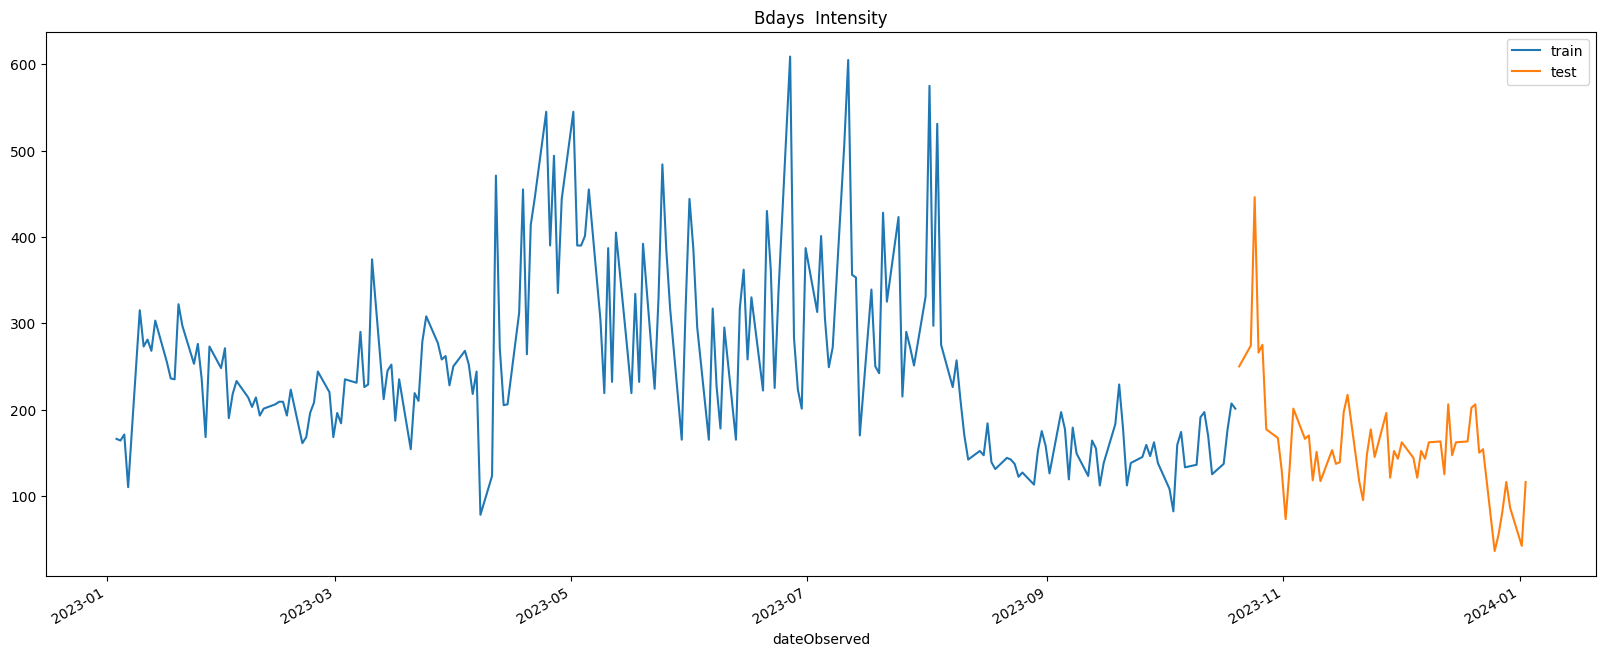

In [12]:
fig, ax = plt.subplots()
data_train.plot(ax=ax, y='filled_intensity', label='train')  
data_test.plot(ax=ax, y='filled_intensity', label='test')   
ax.set_title('Bdays  Intensity')
ax.legend()

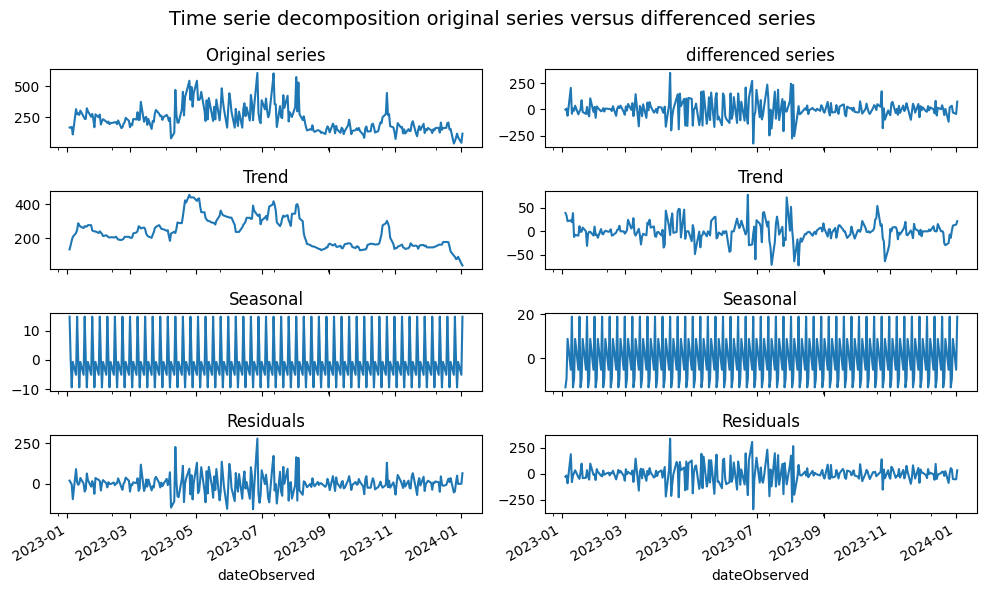

In [13]:
# Time series descoposition of original versus differenced series
# ==============================================================================

res_decompose = seasonal_decompose(data_mlbd.filled_intensity, model='additive', extrapolate_trend='freq')
data_diff_1 = data_mlbd.diff().dropna()
res_decompose2 = seasonal_decompose(data_diff_1.filled_intensity, model='additive', extrapolate_trend='freq')


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0,0])
axs[0,0].set_title('Original series')
res_decompose.trend.plot(ax=axs[1,0])
axs[1,0].set_title('Trend')
res_decompose.seasonal.plot(ax=axs[2,0])
axs[2,0].set_title('Seasonal')
res_decompose.resid.plot(ax=axs[3,0])
axs[3,0].set_title('Residuals')

res_decompose2.observed.plot(ax=axs[0,1])
axs[0,1].set_title('differenced series')
res_decompose2.trend.plot(ax=axs[1,1])
axs[1,1].set_title('Trend')
res_decompose2.seasonal.plot(ax=axs[2,1])
axs[2,1].set_title('Seasonal')
res_decompose2.resid.plot(ax=axs[3,1])
axs[3,1].set_title('Residuals')

fig.suptitle('Time serie decomposition original series versus differenced series', fontsize=14)
fig.tight_layout();


#### Autocorrelation and Partial autocorrelation plots for original and differenced series


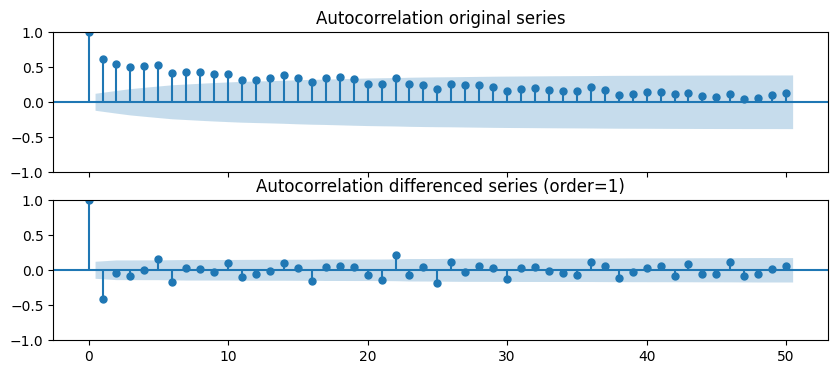

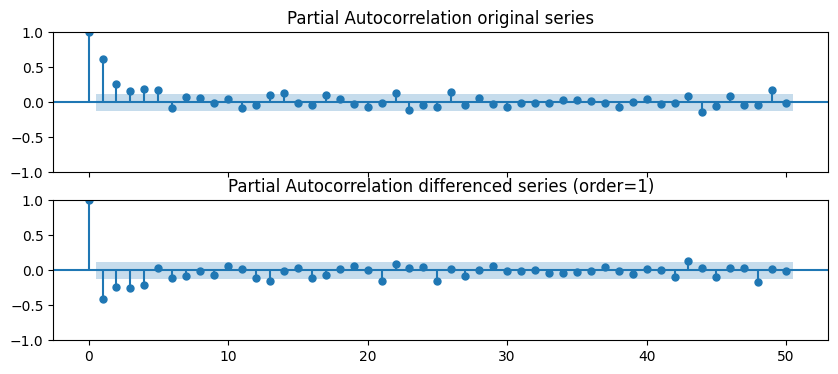

In [14]:
# Autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True)
plot_acf(data_mlbd.filled_intensity, ax=axs[0], lags=50, alpha=0.05) 
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1.filled_intensity, ax=axs[1], lags=50, alpha=0.05)  
axs[1].set_title('Autocorrelation differenced series (order=1)');

# Partial autocorrelation plot for original and differenced series
# ==============================================================================

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True)
plot_pacf(data_mlbd.filled_intensity, ax=axs[0], lags=50, alpha=0.05) 
axs[0].set_title('Partial Autocorrelation original series')
plot_pacf(data_diff_1.filled_intensity, ax=axs[1], lags=50, alpha=0.05)  
axs[1].set_title('Partial Autocorrelation differenced series (order=1)');


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=2419.013, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=2492.541, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=2450.918, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=2414.231, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=2490.542, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=2416.322, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[5] intercept   : AIC=2416.217, Time=0.17 sec
 ARIMA(0,1,1)(0,0,2)[5] intercept   : AIC=2416.227, Time=0.25 sec
 ARIMA(0,1,1)(1,0,0)[5] intercept   : AIC=2414.283, Time=0.08 sec
 ARIMA(0,1,1)(1,0,2)[5] intercept   : AIC=2418.150, Time=0.26 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=2488.857, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=2413.498, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=2416.927, Time=0.09 sec
 ARIMA(1,1,1)(1,0,1)[5] intercept   : AIC=2415.365, Time=0.21 sec
 ARIMA(1,1,1)(0,0,2)[5] intercept

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78286D+00    |proj g|=  6.19549D-02

At iterate    5    f=  5.77880D+00    |proj g|=  6.71811D-03

At iterate   10    f=  5.77872D+00    |proj g|=  2.31454D-03

At iterate   15    f=  5.77767D+00    |proj g|=  1.22940D-02

At iterate   20    f=  5.77736D+00    |proj g|=  1.64192D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     23      1     0     0   1.642D-05   5.777D+00
  F =   5.7773634367654818     

CONVERG

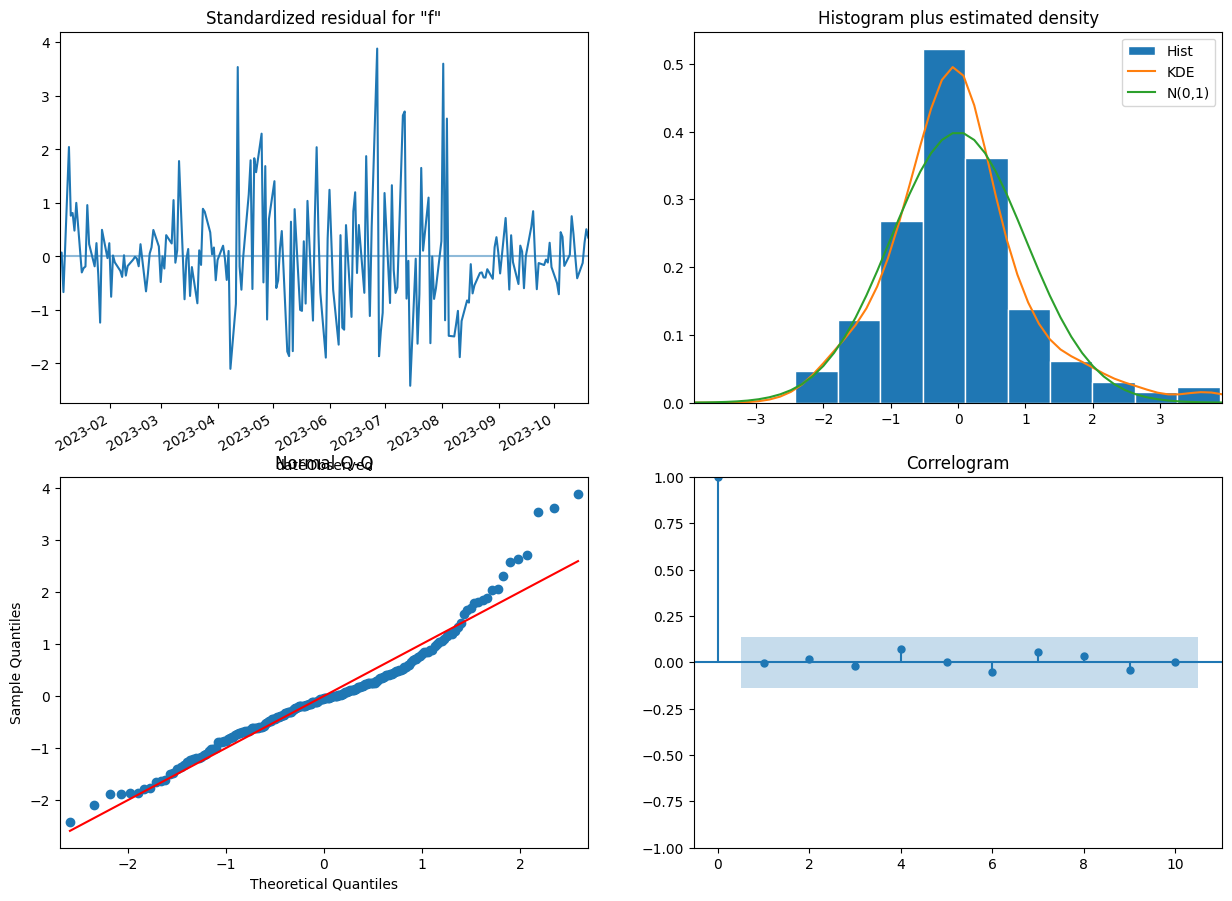

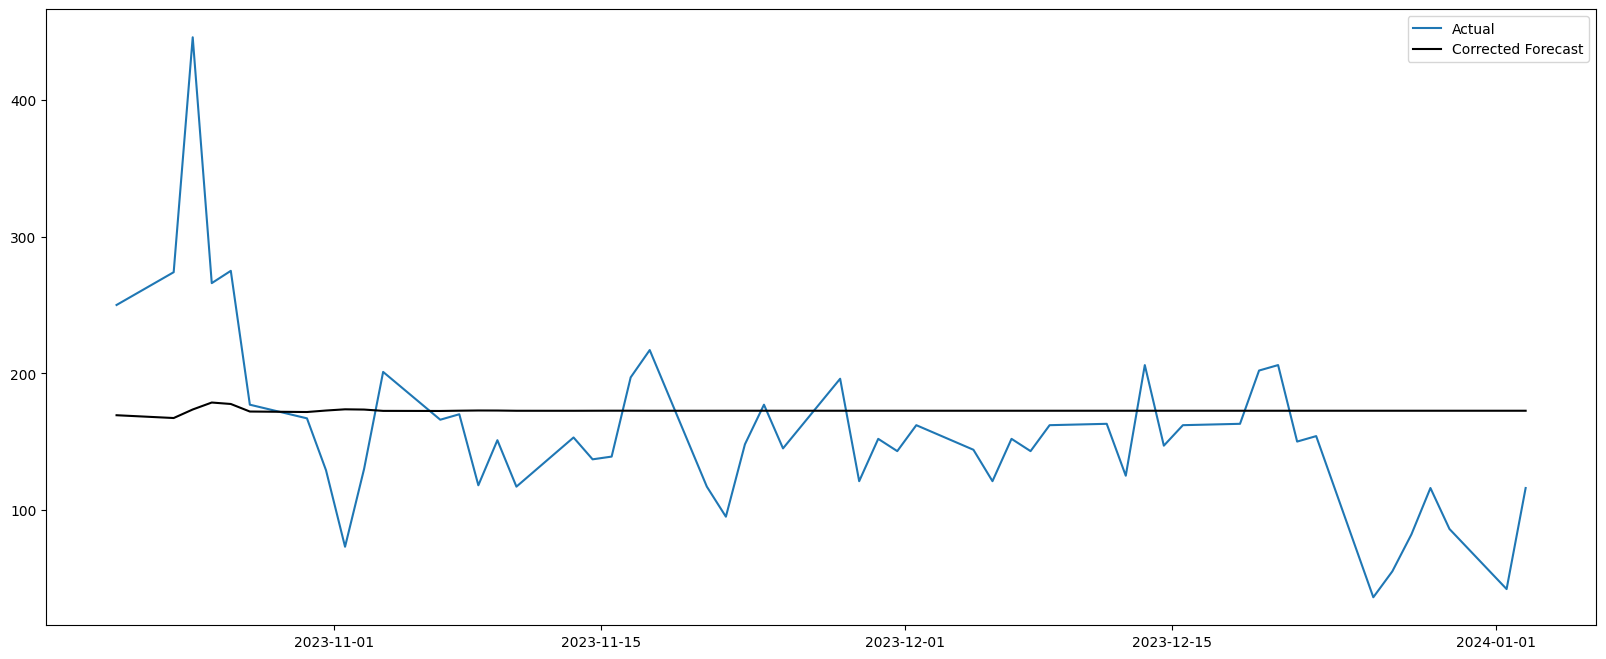

In [15]:
auto_model = pm.auto_arima(data_train['filled_intensity'], seasonal=True, m=5, trace=True,
                           error_action='ignore', suppress_warnings=True)

# Fit SARIMAX 
model = SARIMAX(data_train['filled_intensity'],
                order=auto_model.order,
                seasonal_order=auto_model.seasonal_order)
results = model.fit()

#summary
print(results.summary())
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecast
predictions = results.get_forecast(steps=len(data_test)).predicted_mean

# Ensure there are no negative
if any(predictions < 0):
    print("Some predictions are negative, consider re-evaluating the model setup.")


# Plot corrected forecasts against actual outcomes
plt.plot(data_test['filled_intensity'], label='Actual')
plt.plot(predictions, color='black', label='Corrected Forecast')
plt.legend()
plt.show()


#### Grid Search

In [16]:
#Parameter Grids
p = P = range(1, 4)
d = q = [1]
D =Q = range(0,1)
Q = range(0, 2)  # Seasonal orders
S = [5]  # 5 Bdays, with weekly seasonality

param_grid = list(itertools.product(p, d, q, P, D, Q, S))

best_score = float('inf')
best_params = None

for params in param_grid:

    sarimax_model = sm.tsa.SARIMAX(data_train.filled_intensity, order=params[:3], seasonal_order=params[3:])
    sarimax_result = sarimax_model.fit(maxiter=500)
    
    
    validation_score = sarimax_result.aic
    print("Best parameters:", best_params)
    print("Best score:", best_score)
    
    # Update best score and parameters if current score is better
    if validation_score < best_score:
        best_score = validation_score
        best_params = params

print("Best parameters:", best_params)
print("Best score:", best_score)

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78286D+00    |proj g|=  6.19549D-02

At iterate    5    f=  5.77880D+00    |proj g|=  6.71811D-03

At iterate   10    f=  5.77872D+00    |proj g|=  2.31454D-03

At iterate   15    f=  5.77767D+00    |proj g|=  1.22940D-02

At iterate   20    f=  5.77736D+00    |proj g|=  1.64192D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     23      1     0     0   1.642D-05   5.777D+00
  F =   5.7773634367654818     

CONVERG

 This problem is unconstrained.



At iterate   25    f=  5.77735D+00    |proj g|=  2.44456D-04

At iterate   30    f=  5.77734D+00    |proj g|=  4.46172D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     49      1     0     0   1.962D-05   5.777D+00
  F =   5.7773434409969600     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 5)
Best score: 2411.3831896944403
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78391D+00    |proj g|=  5.34950D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  5.77692D+00    |proj g|=  1.14645D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     22      1     0     0   5.099D-06   5.777D+00
  F =   5.7767915744803382     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 1, 1, 0, 0, 5)
Best score: 2411.3831896944403
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78422D+00    |proj g|=  5.84712D-02

At iterate    5    f=  5.77913D+00    |proj g|=  1.35615D-02


 This problem is unconstrained.



At iterate   15    f=  5.77759D+00    |proj g|=  1.16582D-03

At iterate   20    f=  5.77754D+00    |proj g|=  3.35050D-03

At iterate   25    f=  5.77658D+00    |proj g|=  1.13902D-02

At iterate   30    f=  5.77633D+00    |proj g|=  9.14472D-04

At iterate   35    f=  5.77633D+00    |proj g|=  1.64376D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     57      1     0     0   1.644D-05   5.776D+00
  F =   5.7763268606064804     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 5)
Best score: 2411.3831896944403
RUNNING THE L-BFGS-B CODE

           * * *


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  5.80450D+00    |proj g|=  7.89816D-03

At iterate   15    f=  5.79335D+00    |proj g|=  6.00551D-02

At iterate   20    f=  5.78159D+00    |proj g|=  7.63113D-03

At iterate   25    f=  5.78117D+00    |proj g|=  1.42938D-02

At iterate   30    f=  5.77728D+00    |proj g|=  1.63454D-02

At iterate   35    f=  5.77704D+00    |proj g|=  2.58940D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     50      1     0     0   2.589D-05   5.777D+00
  F =   5.7770449237408794     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 5)
Best score: 

 This problem is unconstrained.



At iterate   10    f=  5.79976D+00    |proj g|=  4.18656D-04

At iterate   15    f=  5.79958D+00    |proj g|=  5.51015D-03

At iterate   20    f=  5.79903D+00    |proj g|=  1.12766D-03

At iterate   25    f=  5.79884D+00    |proj g|=  1.25955D-02

At iterate   30    f=  5.78101D+00    |proj g|=  5.38412D-02

At iterate   35    f=  5.77706D+00    |proj g|=  1.75880D-03

At iterate   40    f=  5.77698D+00    |proj g|=  1.79473D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     58      1     0     0   9.876D-06   5.777D+00
  F =   5.7769796329560279     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   25    f=  5.77967D+00    |proj g|=  2.61590D-02

At iterate   30    f=  5.77700D+00    |proj g|=  2.49317D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     48      1     0     0   1.289D-06   5.777D+00
  F =   5.7769974625440028     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 1, 1, 0, 0, 5)
Best score: 2411.3831896944403
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.81346D+00    |proj g|=  1.44033D-01


 This problem is unconstrained.



At iterate   15    f=  5.79926D+00    |proj g|=  5.05753D-03

At iterate   20    f=  5.79864D+00    |proj g|=  1.75581D-03

At iterate   25    f=  5.79862D+00    |proj g|=  1.73512D-03
  ys=-4.402E-04  -gs= 7.362E-04 BFGS update SKIPPED

At iterate   30    f=  5.78338D+00    |proj g|=  3.61652D-02

At iterate   35    f=  5.77637D+00    |proj g|=  1.40424D-02

At iterate   40    f=  5.77429D+00    |proj g|=  7.14536D-03

At iterate   45    f=  5.77380D+00    |proj g|=  3.84522D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     64      1     1     0   5.880D-06   5.774D+00
  F =   5.7737938437599619     

 This problem is unconstrained.



At iterate    5    f=  5.79788D+00    |proj g|=  4.81471D-04

At iterate   10    f=  5.79776D+00    |proj g|=  8.14241D-03

At iterate   15    f=  5.79718D+00    |proj g|=  1.13543D-03

At iterate   20    f=  5.79715D+00    |proj g|=  2.13817D-03

At iterate   25    f=  5.77852D+00    |proj g|=  3.23423D-02

At iterate   30    f=  5.77651D+00    |proj g|=  5.70630D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     47      1     0     0   1.867D-06   5.777D+00
  F =   5.7765056323266935     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 1, 1, 0, 0, 5)
Best score: 

 This problem is unconstrained.



At iterate   10    f=  5.79688D+00    |proj g|=  9.31735D-03

At iterate   15    f=  5.79682D+00    |proj g|=  1.88746D-03

At iterate   20    f=  5.79618D+00    |proj g|=  5.73820D-03

At iterate   25    f=  5.79612D+00    |proj g|=  1.12671D-03

At iterate   30    f=  5.79384D+00    |proj g|=  4.38857D-02
  ys=-1.146E-04  -gs= 8.588E-04 BFGS update SKIPPED

At iterate   35    f=  5.77746D+00    |proj g|=  2.43350D-02

At iterate   40    f=  5.77699D+00    |proj g|=  4.38988D-04

At iterate   45    f=  5.77699D+00    |proj g|=  5.17356D-05

At iterate   50    f=  5.77699D+00    |proj g|=  3.69898D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  5.77704D+00    |proj g|=  7.98934D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     31      1     0     0   2.787D-05   5.777D+00
  F =   5.7770448467740829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 5)
Best score: 2411.3831896944403
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79019D+00    |proj g|=  4.99444D-02

At iterate    5    f=  5.78452D+00    |proj g|=  3.74440D-02


 This problem is unconstrained.



At iterate   10    f=  5.77900D+00    |proj g|=  8.33519D-03

At iterate   15    f=  5.77820D+00    |proj g|=  8.13716D-04

At iterate   20    f=  5.77811D+00    |proj g|=  5.76052D-03

At iterate   25    f=  5.77702D+00    |proj g|=  3.52171D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     32      1     0     0   1.490D-05   5.777D+00
  F =   5.7769961124412301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 5)
Best score: 2411.3831896944403
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate   25    f=  5.77697D+00    |proj g|=  2.35040D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     31      1     0     0   6.842D-05   5.777D+00
  F =   5.7769733170789115     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 5)
Best score: 2411.3831896944403
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79271D+00    |proj g|=  6.06957D-02

At iterate    5    f=  5.78386D+00    |proj g|=  2.22184D-02


 This problem is unconstrained.



At iterate   10    f=  5.77851D+00    |proj g|=  8.34572D-03

At iterate   15    f=  5.77773D+00    |proj g|=  1.49424D-03

At iterate   20    f=  5.77761D+00    |proj g|=  7.44894D-03

At iterate   25    f=  5.77652D+00    |proj g|=  3.43290D-03

At iterate   30    f=  5.77650D+00    |proj g|=  2.16352D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     38      1     0     0   2.902D-06   5.777D+00
  F =   5.7765010352331654     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 1, 1, 0, 0, 5)
Best score: 2411.3831896944403
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   10    f=  5.77794D+00    |proj g|=  1.91088D-02

At iterate   15    f=  5.77745D+00    |proj g|=  2.33703D-03

At iterate   20    f=  5.77708D+00    |proj g|=  1.83036D-03

At iterate   25    f=  5.77703D+00    |proj g|=  4.20192D-03

At iterate   30    f=  5.77610D+00    |proj g|=  6.28491D-03

At iterate   35    f=  5.77595D+00    |proj g|=  2.56486D-04

At iterate   40    f=  5.77595D+00    |proj g|=  8.39074D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     48      1     0     0   1.035D-05   5.776D+00
  F =   5.7759497186480822     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

#### SARIMA (without Exog)

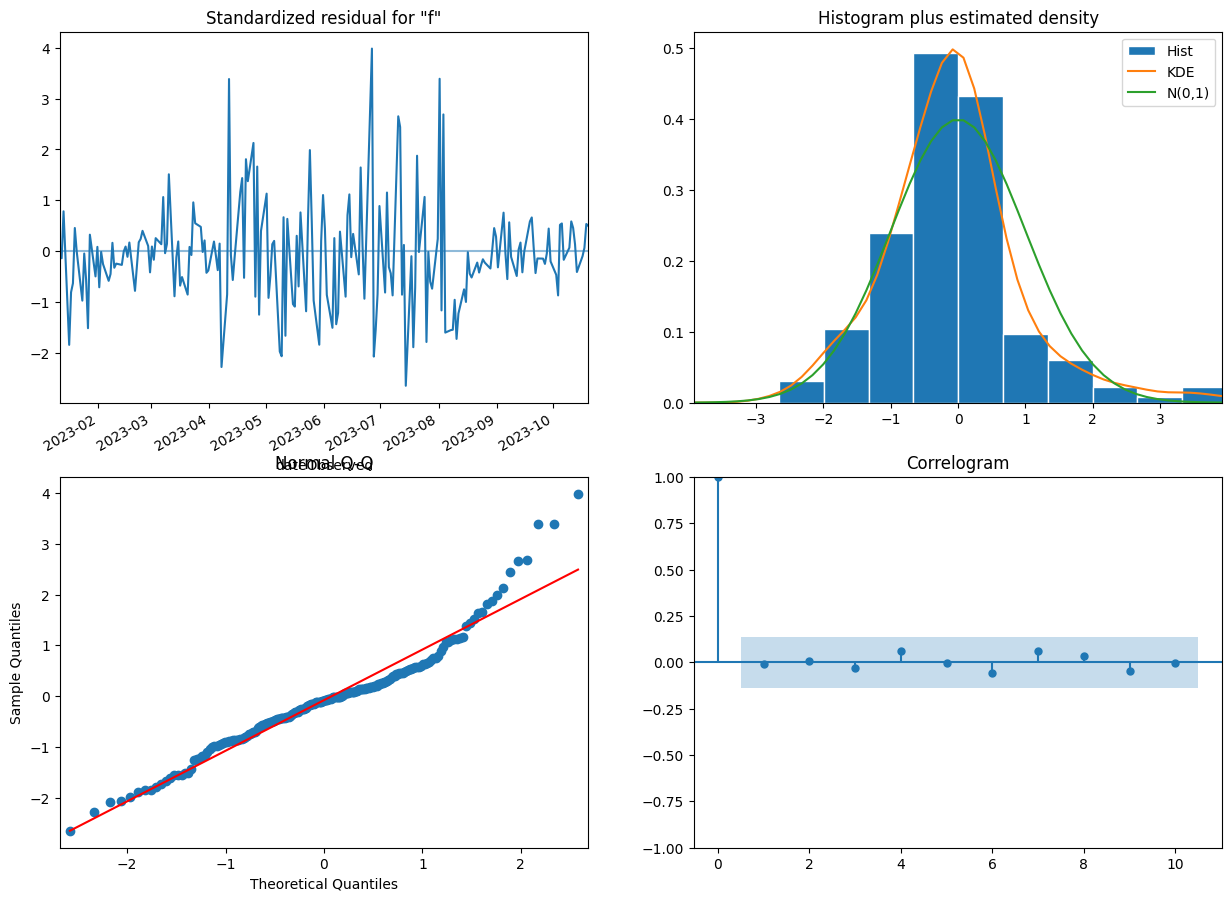

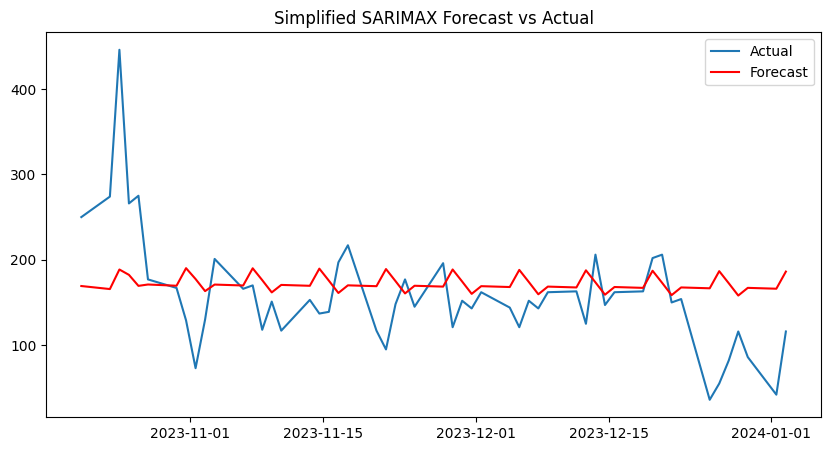

Mean Absolute Error (MAE): 48.35
Root Mean Squared Error (RMSE): 66.907
Mean Absolute Percentage Error (MAPE): 44.88%
Mean Absolute Scaled Error (MASE): 0.68%


In [17]:
# the best parameters Best parameters: (1, 1, 1, 1, 0, 0, 5) did not achieve the best result
#adjustingth the parameters baesd on ACF and PACF 
#order=(0,1,0), seasonal_order=(5, 1,1, 7))
model_BD2 = SARIMAX(data_train['filled_intensity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 5))
results_BD2 = model_BD2.fit(disp=None)
#print(results_BD2.summary())

# diagnostics again
results_BD2.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecast and compare to test set
forecast_BD2 = results_BD2.get_forecast(steps=len(data_test))
mean_forecast_BD2 = forecast_BD2.predicted_mean
#confidence_intervals_BD2 = forecast_BD2.conf_int()

# Plot the forecast against the actual values
plt.figure(figsize=(10, 5))
plt.plot(data_test.index, data_test['filled_intensity'], label='Actual')
plt.plot(mean_forecast_BD2.index, mean_forecast_BD2, color='red', label='Forecast')
#plt.fill_between(mean_forecast_BD2.index, confidence_intervals_BD2.iloc[:, 0], confidence_intervals_BD2.iloc[:, 1], color='pink')
plt.title('Simplified SARIMAX Forecast vs Actual')
plt.legend()
plt.show()


# evaluation 
actual = data_test['filled_intensity'] 
predicted = mean_forecast_BD2
training = data_train['filled_intensity']
mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")


#### SARIMAX (with Exog)
Mean Absolute Error (MAE): 48.35
Root Mean Squared Error (RMSE): 66.907
Mean Absolute Percentage Error (MAPE): 44.88%
Mean Absolute Scaled Error (MASE): 0.68%


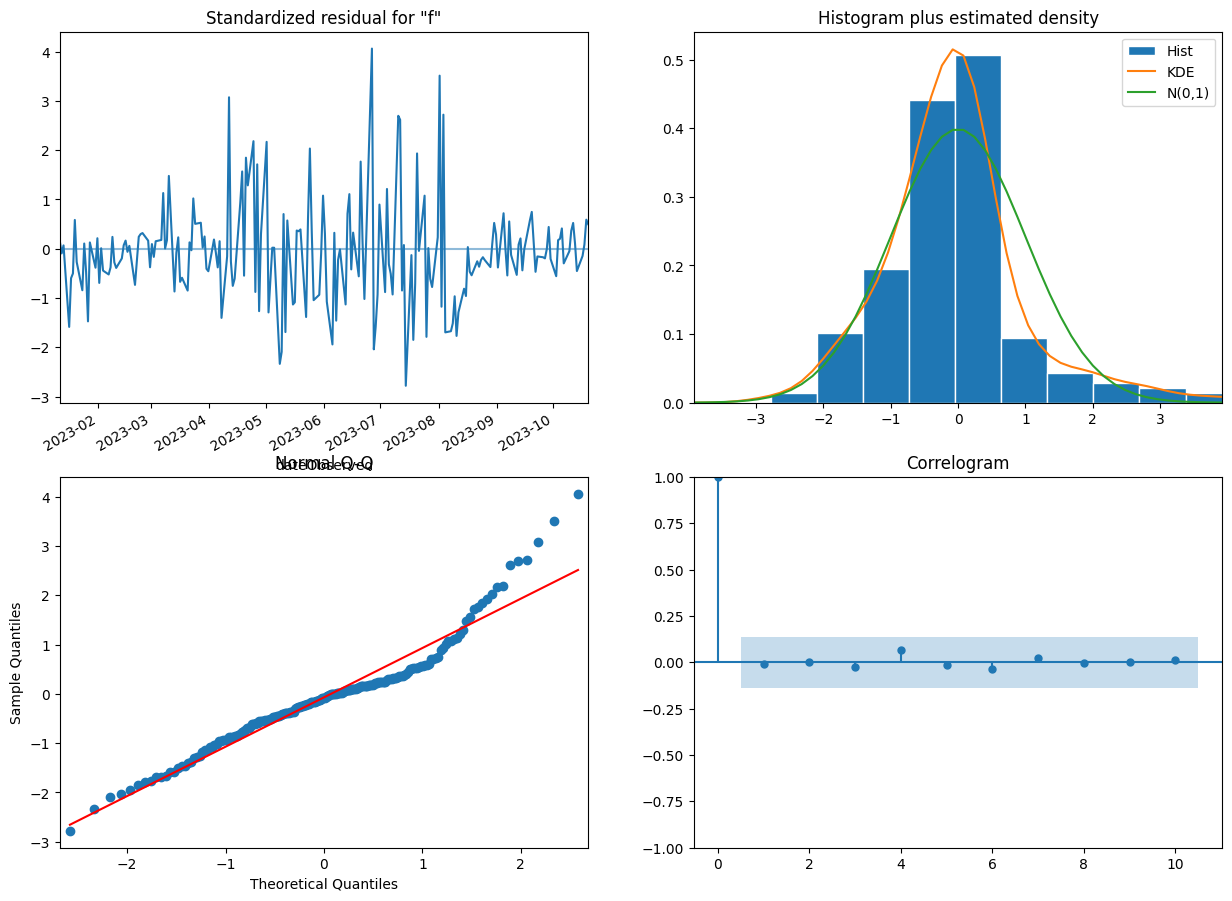

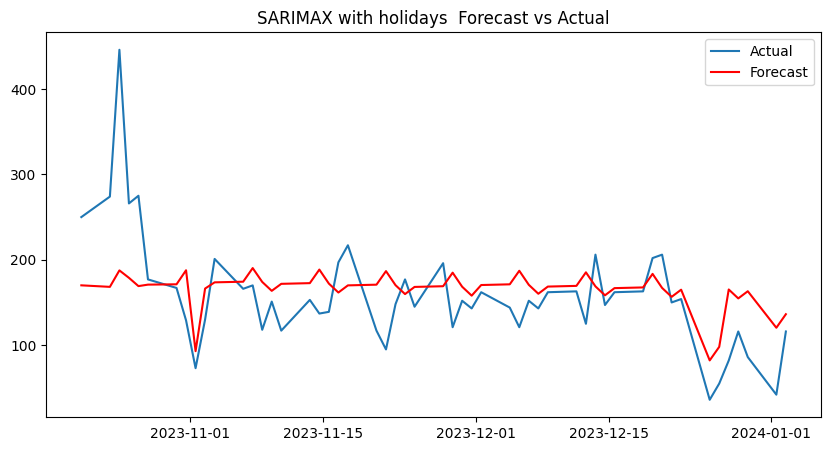

Mean Absolute Error (MAE): 41.32
Root Mean Squared Error (RMSE): 58.193
Mean Absolute Percentage Error (MAPE): 31.89%
Mean Absolute Scaled Error (MASE): 0.58%


In [18]:
exog_data_train = data_train[['is_holiday','dayofweek','month','hour','year']]
exog_data_test = data_test[['is_holiday','dayofweek','month','hour','year']]


model = SARIMAX(data_train['filled_intensity'], exog=exog_data_train, order=(1,1,1), seasonal_order=(1,1,1, 5))
results = model.fit(disp=False)

# check diagnostics 

results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecast using the model
predictions = results.get_forecast(steps=len(data_test), exog=exog_data_test).predicted_mean


plt.figure(figsize=(10, 5))
plt.plot(data_test.index, data_test['filled_intensity'], label='Actual')
plt.plot(predictions.index, predictions, color='red', label='Forecast')
plt.title('SARIMAX with holidays  Forecast vs Actual')
plt.legend()
plt.show()

# evaluation 
actual = data_test['filled_intensity'] 
predicted = predictions
training = data_train['filled_intensity']
mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")


### Frequcney Day 

In [47]:
data_mld = data_ml.asfreq('D') 

# Train-test dates
# ======================================================================================

test_start_date = data_mld.index.max() - pd.DateOffset(months=1)

iloc_TrainEnd = data_mld.index.get_loc(test_start_date)

# Define training and testing datasets
data_trainD2 = data_mld.iloc[:iloc_TrainEnd]
data_testD2 = data_mld.iloc[iloc_TrainEnd:]

# Print training and testing periods
print(f"Train dates : {data_trainD2.index.min()} --- {data_trainD2.index.max()}  (n={len(data_trainD2)})")
print(f"Test dates  : {data_testD2.index.min()} --- {data_testD2.index.max()}  (n={len(data_testD2)})")


Train dates : 2023-01-03 13:40:00+00:00 --- 2023-12-01 13:40:00+00:00  (n=333)
Test dates  : 2023-12-02 13:40:00+00:00 --- 2024-01-02 13:40:00+00:00  (n=32)


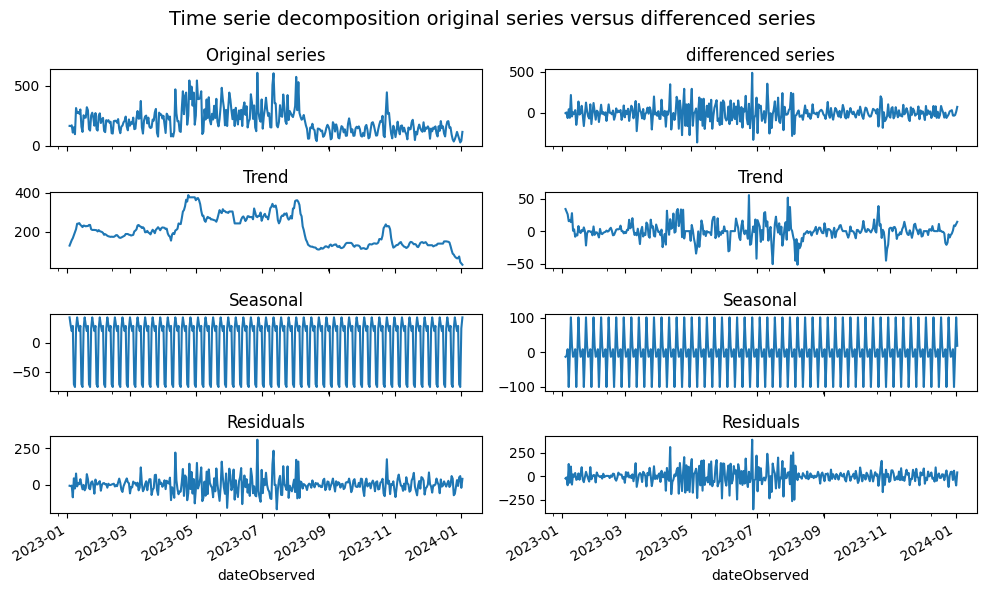

In [48]:
data_diff_1 = data_mld.diff().dropna()

res_decompose = seasonal_decompose(data_mld.filled_intensity, model='additive', extrapolate_trend='freq')
res_decompose2 = seasonal_decompose(data_diff_1.filled_intensity, model='additive', extrapolate_trend='freq')


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0,0])
axs[0,0].set_title('Original series')
res_decompose.trend.plot(ax=axs[1,0])
axs[1,0].set_title('Trend')
res_decompose.seasonal.plot(ax=axs[2,0])
axs[2,0].set_title('Seasonal')
res_decompose.resid.plot(ax=axs[3,0])
axs[3,0].set_title('Residuals')

res_decompose2.observed.plot(ax=axs[0,1])
axs[0,1].set_title('differenced series')
res_decompose2.trend.plot(ax=axs[1,1])
axs[1,1].set_title('Trend')
res_decompose2.seasonal.plot(ax=axs[2,1])
axs[2,1].set_title('Seasonal')
res_decompose2.resid.plot(ax=axs[3,1])
axs[3,1].set_title('Residuals')

fig.suptitle('Time serie decomposition original series versus differenced series', fontsize=14)
fig.tight_layout();


#### Autocorrelation Analysis

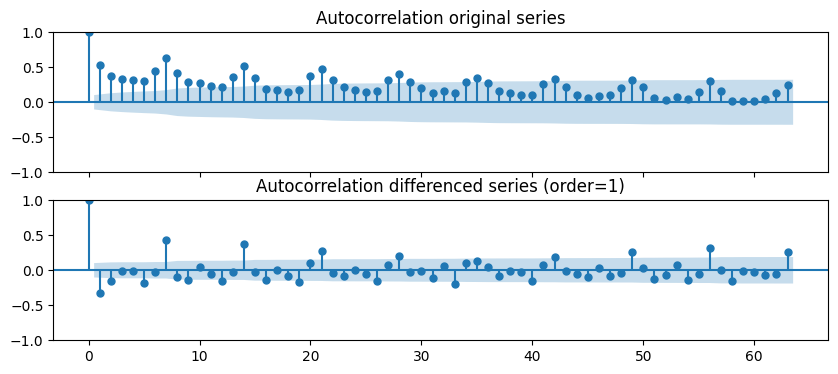

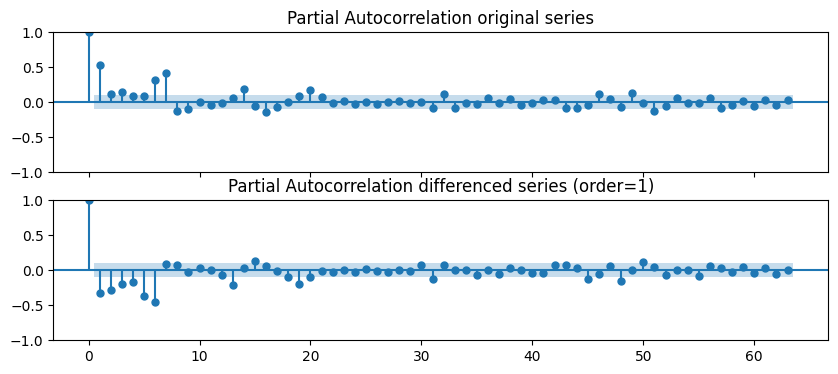

In [49]:
# Autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True)
plot_acf(data_mld.filled_intensity, ax=axs[0], lags=63, alpha=0.05) 
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1.filled_intensity, ax=axs[1], lags=63, alpha=0.05)  
axs[1].set_title('Autocorrelation differenced series (order=1)');

# Partial autocorrelation plot for original and differenced series
# ==============================================================================

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True)
plot_pacf(data_mld.filled_intensity, ax=axs[0], lags=63, alpha=0.05) 
axs[0].set_title('Partial Autocorrelation original series')
plot_pacf(data_diff_1.filled_intensity, ax=axs[1], lags=63, alpha=0.05)  
axs[1].set_title('Partial Autocorrelation differenced series (order=1)');


#### Grid Search

In [22]:
#Parameter Grids
p = P = range(1,7)
d = [1]
q = Q = range(0, 2)  # Seasonal orders
S = [7]  # 7 for with weekly seasonality

param_grid = list(itertools.product(p, d, q, P, D, Q, S))

best_score = float('inf')
best_params = None

for params in param_grid:

    sarimax_model = sm.tsa.SARIMAX(data_train.filled_intensity, order=params[:3], seasonal_order=params[3:])
    sarimax_result = sarimax_model.fit(maxiter=500)
    
    
    validation_score = sarimax_result.aic
    print("Best parameters:", best_params)
    print("Best score:", best_score)
    
    # Update best score and parameters if current score is better
    if validation_score < best_score:
        best_score = validation_score
        best_params = params

print("Best parameters:", best_params)
print("Best score:", best_score)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.88789D+00    |proj g|=  5.27158D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   5.549D-05   5.886D+00
  F =   5.8864849776828168     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: None
Best score: inf
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at 

 This problem is unconstrained.
 This problem is unconstrained.


Best parameters: (1, 1, 0, 1, 0, 0, 7)
Best score: 2454.7777507160517
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.87801D+00    |proj g|=  6.81208D-02

At iterate    5    f=  5.87433D+00    |proj g|=  3.45432D-04

At iterate   10    f=  5.87424D+00    |proj g|=  6.35886D-03

At iterate   15    f=  5.87408D+00    |proj g|=  3.82590D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     19      1     0     0   2.149D-07   5.874D+00
  F =   5.8740809290574898     


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  5.86763D+00    |proj g|=  9.18629D-03

At iterate   25    f=  5.86744D+00    |proj g|=  3.19903D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     30      1     0     0   2.603D-05   5.867D+00
  F =   5.8674389838538490     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 0, 2, 0, 0, 7)
Best score: 2451.617666487916
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.87207D+00    |proj g|=  6.53109D-02



 This problem is unconstrained.



At iterate   15    f=  5.86759D+00    |proj g|=  1.75034D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   1.205D-05   5.868D+00
  F =   5.8675931784157029     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 0, 2, 0, 1, 7)
Best score: 2450.854617283201
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.87284D+00    |proj g|=  6.26169D-02

At iterate    5    f=  5.86781D+00    |proj g|=  5.29728D-03



 This problem is unconstrained.



At iterate   15    f=  5.86668D+00    |proj g|=  1.88163D-03

At iterate   20    f=  5.86624D+00    |proj g|=  9.51592D-03

At iterate   25    f=  5.86612D+00    |proj g|=  3.97094D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     29      1     0     0   2.999D-05   5.866D+00
  F =   5.8661212821757083     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 0, 2, 0, 1, 7)
Best score: 2450.854617283201
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.



At iterate    5    f=  5.86603D+00    |proj g|=  5.47952D-04

At iterate   10    f=  5.86578D+00    |proj g|=  1.48311D-02

At iterate   15    f=  5.86540D+00    |proj g|=  2.96853D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     21      1     0     0   7.034D-06   5.865D+00
  F =   5.8654026886529449     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 0, 2, 0, 1, 7)
Best score: 2450.854617283201
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.



At iterate    5    f=  5.86602D+00    |proj g|=  5.48771D-04

At iterate   10    f=  5.86594D+00    |proj g|=  5.27399D-03

At iterate   15    f=  5.86589D+00    |proj g|=  1.47564D-03

At iterate   20    f=  5.86557D+00    |proj g|=  1.19300D-02

At iterate   25    f=  5.86537D+00    |proj g|=  8.98117D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     31      1     0     0   2.487D-05   5.865D+00
  F =   5.8653737272044246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 0, 2, 0, 1, 7)
Best score: 2450.854617283201
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f=  5.86593D+00    |proj g|=  6.96949D-04

At iterate   10    f=  5.86550D+00    |proj g|=  1.05640D-02

At iterate   15    f=  5.86530D+00    |proj g|=  3.06692D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     20      1     0     0   1.976D-05   5.865D+00
  F =   5.8653005583190652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 0, 2, 0, 1, 7)
Best score: 2450.854617283201
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.



At iterate    5    f=  5.86596D+00    |proj g|=  5.50222D-04

At iterate   10    f=  5.86577D+00    |proj g|=  1.53177D-02

At iterate   15    f=  5.86476D+00    |proj g|=  5.14729D-03

At iterate   20    f=  5.86462D+00    |proj g|=  3.84406D-04

At iterate   25    f=  5.86461D+00    |proj g|=  9.57659D-04

At iterate   30    f=  5.86454D+00    |proj g|=  1.10415D-03

At iterate   35    f=  5.86453D+00    |proj g|=  8.82903D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     40      1     0     0   8.829D-06   5.865D+00
  F =   5.8645323486603385     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.86303D+00    |proj g|=  6.28256D-04

At iterate   10    f=  5.86287D+00    |proj g|=  1.28426D-02

At iterate   15    f=  5.86220D+00    |proj g|=  1.58111D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     18     22      1     0     0   1.084D-05   5.862D+00
  F =   5.8621928607772844     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 0, 2, 0, 1, 7)
Best score: 2450.854617283201
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.



At iterate    5    f=  5.86281D+00    |proj g|=  2.84080D-03

At iterate   10    f=  5.86085D+00    |proj g|=  1.01216D-02

At iterate   15    f=  5.86059D+00    |proj g|=  2.16945D-03

At iterate   20    f=  5.86056D+00    |proj g|=  2.07182D-03

At iterate   25    f=  5.85990D+00    |proj g|=  5.36383D-03

At iterate   30    f=  5.85973D+00    |proj g|=  1.35114D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     37      1     0     0   1.231D-05   5.860D+00
  F =   5.8597329343355220     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 0, 2, 0, 1, 7)
Best score: 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.79122D+00    |proj g|=  8.41465D-04

At iterate   10    f=  5.79038D+00    |proj g|=  1.94625D-03

At iterate   15    f=  5.79035D+00    |proj g|=  7.38352D-04

At iterate   20    f=  5.79017D+00    |proj g|=  8.63176D-03

At iterate   25    f=  5.79012D+00    |proj g|=  2.73450D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     32      1     0     0   1.776D-05   5.790D+00
  F =   5.7901189262118971     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.78783D+00    |proj g|=  1.56083D-03

At iterate   10    f=  5.78770D+00    |proj g|=  4.87749D-03

At iterate   15    f=  5.78706D+00    |proj g|=  6.70303D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   8.811D-06   5.787D+00
  F =   5.7870599751902132     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79166D+00    |proj g|=  6.75850D-02
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557


 This problem is unconstrained.



At iterate    5    f=  5.78693D+00    |proj g|=  1.28863D-02

At iterate   10    f=  5.78355D+00    |proj g|=  7.90520D-03

At iterate   15    f=  5.78342D+00    |proj g|=  9.48178D-04

At iterate   20    f=  5.78318D+00    |proj g|=  8.81370D-03

At iterate   25    f=  5.78245D+00    |proj g|=  1.39657D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     30      1     0     0   2.956D-05   5.782D+00
  F =   5.7824458684912923     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.78274D+00    |proj g|=  1.35704D-02

At iterate   10    f=  5.78181D+00    |proj g|=  2.08748D-03

At iterate   15    f=  5.78174D+00    |proj g|=  7.93227D-04

At iterate   20    f=  5.78166D+00    |proj g|=  8.11298D-03

At iterate   25    f=  5.78070D+00    |proj g|=  3.40543D-03

At iterate   30    f=  5.78064D+00    |proj g|=  5.66435D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     36      1     0     0   3.951D-05   5.781D+00
  F =   5.7806357564438633     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 

 This problem is unconstrained.



At iterate    5    f=  5.78122D+00    |proj g|=  1.42273D-03

At iterate   10    f=  5.78096D+00    |proj g|=  4.84675D-03

At iterate   15    f=  5.77997D+00    |proj g|=  1.68945D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     22      1     0     0   4.522D-06   5.780D+00
  F =   5.7799642654723016     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.78116D+00    |proj g|=  1.55552D-03

At iterate   10    f=  5.78094D+00    |proj g|=  3.86388D-03

At iterate   15    f=  5.78076D+00    |proj g|=  5.72916D-03

At iterate   20    f=  5.77986D+00    |proj g|=  6.00044D-04

At iterate   25    f=  5.77986D+00    |proj g|=  3.08233D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     28      1     0     0   3.082D-06   5.780D+00
  F =   5.7798602533983772     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.78093D+00    |proj g|=  1.82850D-03

At iterate   10    f=  5.78045D+00    |proj g|=  1.80981D-02

At iterate   15    f=  5.77965D+00    |proj g|=  1.03830D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     18     20      1     0     0   3.270D-06   5.780D+00
  F =   5.7796498145240642     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.78099D+00    |proj g|=  1.10224D-03

At iterate   10    f=  5.78062D+00    |proj g|=  1.19096D-02

At iterate   15    f=  5.78001D+00    |proj g|=  3.46443D-03

At iterate   20    f=  5.77960D+00    |proj g|=  1.43971D-03

At iterate   25    f=  5.77957D+00    |proj g|=  3.32616D-04

At iterate   30    f=  5.77956D+00    |proj g|=  1.28649D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     34      1     0     0   1.286D-05   5.780D+00
  F =   5.7795639467268085     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 

 This problem is unconstrained.



At iterate    5    f=  5.77933D+00    |proj g|=  1.35899D-03

At iterate   10    f=  5.77928D+00    |proj g|=  1.50621D-03

At iterate   15    f=  5.77855D+00    |proj g|=  1.66855D-02

At iterate   20    f=  5.77789D+00    |proj g|=  2.41469D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     22     25      1     0     0   2.085D-05   5.778D+00
  F =   5.7778946191488210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =     

 This problem is unconstrained.



At iterate    5    f=  5.77911D+00    |proj g|=  3.44503D-03

At iterate   10    f=  5.77818D+00    |proj g|=  1.21056D-02

At iterate   15    f=  5.77699D+00    |proj g|=  1.50864D-02

At iterate   20    f=  5.77657D+00    |proj g|=  7.72541D-04

At iterate   25    f=  5.77641D+00    |proj g|=  3.85340D-03

At iterate   30    f=  5.77579D+00    |proj g|=  2.86494D-03

At iterate   35    f=  5.77550D+00    |proj g|=  1.67431D-03

At iterate   40    f=  5.77547D+00    |proj g|=  3.90957D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     42     47      1     0     0   1.872D-06   5.775D+00
  F =   5.77546513518

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  5.84349D+00    |proj g|=  7.40557D-04

At iterate   25    f=  5.84344D+00    |proj g|=  3.83061D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     40      1     0     0   2.398D-05   5.843D+00
  F =   5.8434095714044911     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.84344D+00    |proj g|=  3.77157D-02


 This problem is unconstrained.
 This problem is unconstrained.


Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557

At iterate    5    f=  5.84157D+00    |proj g|=  3.12048D-04

At iterate   10    f=  5.84151D+00    |proj g|=  7.17110D-03

At iterate   15    f=  5.84138D+00    |proj g|=  2.12426D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   8.241D-07   5.841D+00
  F =   5.8413775824030312     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate   10    f=  5.83557D+00    |proj g|=  8.95960D-03

At iterate   15    f=  5.83539D+00    |proj g|=  4.30074D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     20      1     0     0   1.526D-05   5.835D+00
  F =   5.8353897436567346     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83864D+00    |proj g|=  4.94569D-02


 This problem is unconstrained.



At iterate   10    f=  5.83343D+00    |proj g|=  5.07077D-04

At iterate   15    f=  5.83339D+00    |proj g|=  2.48408D-03

At iterate   20    f=  5.83293D+00    |proj g|=  1.03620D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     28      1     0     0   4.709D-06   5.833D+00
  F =   5.8329271793944448     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate   15    f=  5.83072D+00    |proj g|=  2.96594D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     20      1     0     0   1.150D-05   5.831D+00
  F =   5.8307239928975028     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83542D+00    |proj g|=  6.38541D-02


 This problem is unconstrained.



At iterate    5    f=  5.83139D+00    |proj g|=  7.43369D-04

At iterate   10    f=  5.83132D+00    |proj g|=  2.34486D-03

At iterate   15    f=  5.83129D+00    |proj g|=  2.67151D-03

At iterate   20    f=  5.83081D+00    |proj g|=  7.11227D-03

At iterate   25    f=  5.83072D+00    |proj g|=  8.28075D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     26     29      1     0     0   7.402D-05   5.831D+00
  F =   5.8307199407322532     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.83136D+00    |proj g|=  5.72964D-04

At iterate   10    f=  5.83104D+00    |proj g|=  9.07988D-03

At iterate   15    f=  5.83072D+00    |proj g|=  1.01791D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     16     20      1     0     0   2.223D-05   5.831D+00
  F =   5.8307151021110224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.83135D+00    |proj g|=  5.73507D-04

At iterate   10    f=  5.83113D+00    |proj g|=  1.52526D-02

At iterate   15    f=  5.82850D+00    |proj g|=  5.70774D-03

At iterate   20    f=  5.82839D+00    |proj g|=  3.78365D-03

At iterate   25    f=  5.82778D+00    |proj g|=  7.09038D-03

At iterate   30    f=  5.82770D+00    |proj g|=  5.67267D-04

At iterate   35    f=  5.82770D+00    |proj g|=  1.39120D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     38      1     0     0   1.391D-05   5.828D+00
  F =   5.8276969321480294     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83604D+00    |proj g|=  6.38280D-02

At iterate    5    f=  5.82973D+00    |proj g|=  6.17879D-04

At iterate   10    f=  5.82960D+00    |proj g|=  6.09864D-03

At iterate   15    f=  5.82898D+00    |proj g|=  9.32524D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     19     22      1     0     0   1.187D-06   5.829D+00
  F =   5.8289789535971579     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best par

 This problem is unconstrained.



At iterate    5    f=  5.82951D+00    |proj g|=  3.27479D-03

At iterate   10    f=  5.82762D+00    |proj g|=  1.58361D-02

At iterate   15    f=  5.82691D+00    |proj g|=  4.65229D-03

At iterate   20    f=  5.82687D+00    |proj g|=  6.07900D-04

At iterate   25    f=  5.82665D+00    |proj g|=  4.78757D-03

At iterate   30    f=  5.82615D+00    |proj g|=  1.73327D-03

At iterate   35    f=  5.82615D+00    |proj g|=  6.43974D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     35     38      1     0     0   6.440D-05   5.826D+00
  F =   5.8261479177238433     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   25    f=  5.80564D+00    |proj g|=  2.69219D-02

At iterate   30    f=  5.79030D+00    |proj g|=  4.09541D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     46      1     0     0   9.252D-07   5.790D+00
  F =   5.7902796290229839     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.84701D+00    |proj g|=  1.34166D-01


 This problem is unconstrained.



At iterate   15    f=  5.82626D+00    |proj g|=  2.77202D-04

At iterate   20    f=  5.82621D+00    |proj g|=  5.41713D-03
  ys=-3.910E-03  -gs= 1.525E-03 BFGS update SKIPPED

At iterate   25    f=  5.80544D+00    |proj g|=  3.87837D-02

At iterate   30    f=  5.79836D+00    |proj g|=  1.40251D-02

At iterate   35    f=  5.79796D+00    |proj g|=  4.79126D-03

At iterate   40    f=  5.79006D+00    |proj g|=  1.32265D-03

At iterate   45    f=  5.78989D+00    |proj g|=  1.60766D-03

At iterate   50    f=  5.78929D+00    |proj g|=  1.59583D-02

At iterate   55    f=  5.78799D+00    |proj g|=  8.79441D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.



At iterate   15    f=  5.80840D+00    |proj g|=  6.19339D-02

At iterate   20    f=  5.78758D+00    |proj g|=  1.49288D-02

At iterate   25    f=  5.78712D+00    |proj g|=  2.09429D-04

At iterate   30    f=  5.78711D+00    |proj g|=  1.62803D-03

At iterate   35    f=  5.78704D+00    |proj g|=  7.90317D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     53      1     0     0   2.602D-05   5.787D+00
  F =   5.7870433544889854     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   20    f=  5.81047D+00    |proj g|=  1.12196D-02

At iterate   25    f=  5.79351D+00    |proj g|=  5.25790D-02

At iterate   30    f=  5.78573D+00    |proj g|=  1.65009D-02

At iterate   35    f=  5.78465D+00    |proj g|=  5.10378D-03

At iterate   40    f=  5.78432D+00    |proj g|=  6.32568D-03

At iterate   45    f=  5.78252D+00    |proj g|=  1.02574D-02

At iterate   50    f=  5.78244D+00    |proj g|=  4.16883D-04

At iterate   55    f=  5.78244D+00    |proj g|=  1.51823D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     55     67      1     0     0   1.518D-05   5.782D+00
  F =   5.78244286941

 This problem is unconstrained.



At iterate   10    f=  5.81242D+00    |proj g|=  8.14451D-04

At iterate   15    f=  5.80232D+00    |proj g|=  6.92862D-02

At iterate   20    f=  5.78779D+00    |proj g|=  5.26826D-02

At iterate   25    f=  5.78301D+00    |proj g|=  1.18079D-03

At iterate   30    f=  5.78289D+00    |proj g|=  6.66080D-03

At iterate   35    f=  5.78228D+00    |proj g|=  1.33636D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     55      1     0     0   1.761D-05   5.782D+00
  F =   5.7822749662935369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 

 This problem is unconstrained.



At iterate    5    f=  5.81188D+00    |proj g|=  5.70574D-03

At iterate   10    f=  5.81061D+00    |proj g|=  7.91905D-03

At iterate   15    f=  5.81044D+00    |proj g|=  2.39911D-04

At iterate   20    f=  5.81036D+00    |proj g|=  6.47765D-03

At iterate   25    f=  5.79085D+00    |proj g|=  5.34412D-02

At iterate   30    f=  5.78316D+00    |proj g|=  4.74878D-03

At iterate   35    f=  5.78250D+00    |proj g|=  5.46519D-03

At iterate   40    f=  5.78237D+00    |proj g|=  6.56806D-03

At iterate   45    f=  5.78087D+00    |proj g|=  1.18075D-02

At iterate   50    f=  5.78065D+00    |proj g|=  1.12329D-03

At iterate   55    f=  5.78064D+00    |proj g|=  3.77046D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.



At iterate    5    f=  5.80870D+00    |proj g|=  1.21731D-03

At iterate   10    f=  5.80869D+00    |proj g|=  5.65993D-04

At iterate   15    f=  5.80851D+00    |proj g|=  9.55537D-03

At iterate   20    f=  5.79573D+00    |proj g|=  5.34190D-02

At iterate   25    f=  5.78490D+00    |proj g|=  5.17843D-03

At iterate   30    f=  5.78458D+00    |proj g|=  1.04005D-02

At iterate   35    f=  5.78064D+00    |proj g|=  2.24335D-02

At iterate   40    f=  5.77996D+00    |proj g|=  2.09692D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     55      1     0     0   8.372D-06   5.780D+00
  F =   5.77996180441

 This problem is unconstrained.



At iterate    5    f=  5.80868D+00    |proj g|=  3.41531D-03

At iterate   10    f=  5.80865D+00    |proj g|=  1.82462D-03

At iterate   15    f=  5.80846D+00    |proj g|=  6.26046D-03

At iterate   20    f=  5.80828D+00    |proj g|=  1.27035D-02

At iterate   25    f=  5.79200D+00    |proj g|=  5.84921D-02

At iterate   30    f=  5.78450D+00    |proj g|=  1.64266D-02

At iterate   35    f=  5.78403D+00    |proj g|=  5.03173D-03

At iterate   40    f=  5.78113D+00    |proj g|=  2.93860D-02

At iterate   45    f=  5.77987D+00    |proj g|=  1.34561D-03

At iterate   50    f=  5.77986D+00    |proj g|=  5.08836D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80859D+00    |proj g|=  1.92799D-03

At iterate   10    f=  5.80857D+00    |proj g|=  1.61443D-03

At iterate   15    f=  5.80377D+00    |proj g|=  4.88857D-02

At iterate   20    f=  5.79477D+00    |proj g|=  6.48582D-02

At iterate   25    f=  5.78497D+00    |proj g|=  2.31538D-03

At iterate   30    f=  5.78411D+00    |proj g|=  2.43716D-02

At iterate   35    f=  5.77966D+00    |proj g|=  3.30086D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     52      1     0     0   4.513D-06   5.780D+00
  F =   5.7796496362404177     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.80867D+00    |proj g|=  3.74410D-03

At iterate   10    f=  5.80862D+00    |proj g|=  2.43265D-03

At iterate   15    f=  5.80751D+00    |proj g|=  1.79089D-02

At iterate   20    f=  5.80555D+00    |proj g|=  6.90137D-03

At iterate   25    f=  5.80519D+00    |proj g|=  5.07062D-03

At iterate   30    f=  5.80436D+00    |proj g|=  5.38003D-03

At iterate   35    f=  5.78572D+00    |proj g|=  3.87119D-02

At iterate   40    f=  5.78085D+00    |proj g|=  4.39704D-03

At iterate   45    f=  5.78063D+00    |proj g|=  8.52467D-04

At iterate   50    f=  5.78018D+00    |proj g|=  1.03820D-02

At iterate   55    f=  5.77950D+00    |proj g|=  4.40107D-04

At iterate   60    f=  5.77947D+00    |proj g|=  1.41940D-03

At iterate   65    f=  5.77946D+00    |proj g|=  2.28381D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.



At iterate    5    f=  5.80598D+00    |proj g|=  2.80233D-03

At iterate   10    f=  5.80595D+00    |proj g|=  5.53393D-04

At iterate   15    f=  5.80580D+00    |proj g|=  8.43620D-03

At iterate   20    f=  5.80544D+00    |proj g|=  8.28103D-04

At iterate   25    f=  5.80540D+00    |proj g|=  3.25726D-03

At iterate   30    f=  5.78763D+00    |proj g|=  4.86786D-02

At iterate   35    f=  5.77804D+00    |proj g|=  7.50753D-03

At iterate   40    f=  5.77789D+00    |proj g|=  5.81976D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     43     59      1     0     0   3.146D-06   5.778D+00
  F =   5.77788605742

 This problem is unconstrained.



At iterate    5    f=  5.80561D+00    |proj g|=  3.99452D-03

At iterate   10    f=  5.80471D+00    |proj g|=  1.50531D-02

At iterate   15    f=  5.80339D+00    |proj g|=  1.40094D-03

At iterate   20    f=  5.80336D+00    |proj g|=  3.44929D-04

At iterate   25    f=  5.80324D+00    |proj g|=  5.59258D-03

At iterate   30    f=  5.80275D+00    |proj g|=  6.50097D-04

At iterate   35    f=  5.80268D+00    |proj g|=  3.71012D-03

At iterate   40    f=  5.79494D+00    |proj g|=  6.13686D-02

At iterate   45    f=  5.77827D+00    |proj g|=  1.73469D-02

At iterate   50    f=  5.77728D+00    |proj g|=  1.06606D-02

At iterate   55    f=  5.77701D+00    |proj g|=  3.30610D-03

At iterate   60    f=  5.77686D+00    |proj g|=  6.76077D-03

At iterate   65    f=  5.77562D+00    |proj g|=  7.89490D-03

At iterate   70    f=  5.77547D+00    |proj g|=  4.20935D-03

At iterate   75    f=  5.77545D+00    |proj g|=  2.22356D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.81133D+00    |proj g|=  3.55915D-03

At iterate   15    f=  5.81131D+00    |proj g|=  1.90435D-04

At iterate   20    f=  5.81128D+00    |proj g|=  2.28443D-03

At iterate   25    f=  5.81125D+00    |proj g|=  3.60338D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     29      1     0     0   6.126D-06   5.811D+00
  F =   5.8112523149538937     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =     

 This problem is unconstrained.


Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557

At iterate    5    f=  5.80940D+00    |proj g|=  2.48453D-04

At iterate   10    f=  5.80939D+00    |proj g|=  4.74792D-03

At iterate   15    f=  5.80929D+00    |proj g|=  6.89947D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     22      1     0     0   5.521D-06   5.809D+00
  F =   5.8092927538919197     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate   15    f=  5.80525D+00    |proj g|=  8.70163D-04

At iterate   20    f=  5.80505D+00    |proj g|=  1.65467D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     26      1     0     0   1.380D-05   5.805D+00
  F =   5.8050490496625766     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.80903D+00    |proj g|=  7.12338D-02


 This problem is unconstrained.



At iterate   10    f=  5.80606D+00    |proj g|=  4.77492D-03

At iterate   15    f=  5.80590D+00    |proj g|=  4.16127D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     19      1     0     0   8.600D-06   5.806D+00
  F =   5.8058978684545037     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.80841D+00    |proj g|=  6.73932D-02

At iterate    5    f=  5.80552D+00    |proj g|=  8.68878D-03

At iterate   10    f=  5.80405D+00    |proj g|=  5.83026D-03

At iterate   15    f=  5.80400D+00    |proj g|=  6.06001D-04

At iterate   20    f=  5.80390D+00    |proj g|=  6.55157D-03

At iterate   25    f=  5.80375D+00    |proj g|=  4.96621D-04

At iterate   30    f=  5.80375D+00    |proj g|=  2.19824D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     34     

 This problem is unconstrained.



At iterate   10    f=  5.80243D+00    |proj g|=  5.83308D-03

At iterate   15    f=  5.80214D+00    |proj g|=  1.62167D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     18     21      1     0     0   1.146D-05   5.802D+00
  F =   5.8021377190132801     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.80585D+00    |proj g|=  7.58496D-02


 This problem is unconstrained.



At iterate   10    f=  5.80238D+00    |proj g|=  2.75856D-03

At iterate   15    f=  5.80217D+00    |proj g|=  5.38735D-03

At iterate   20    f=  5.80208D+00    |proj g|=  3.65501D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     21     24      1     0     0   1.168D-05   5.802D+00
  F =   5.8020781221106983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.80235D+00    |proj g|=  4.35433D-04

At iterate   10    f=  5.80229D+00    |proj g|=  4.15969D-03

At iterate   15    f=  5.80201D+00    |proj g|=  1.34502D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     18     20      1     0     0   6.559D-06   5.802D+00
  F =   5.8020068635618198     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.80239D+00    |proj g|=  4.34485D-04

At iterate   10    f=  5.80226D+00    |proj g|=  7.16061D-03

At iterate   15    f=  5.80205D+00    |proj g|=  5.71152D-04

At iterate   20    f=  5.80205D+00    |proj g|=  9.22290D-04

At iterate   25    f=  5.80190D+00    |proj g|=  7.95475D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     29     32      1     0     0   1.670D-05   5.802D+00
  F =   5.8019014436664857     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.80140D+00    |proj g|=  4.62479D-04

At iterate   10    f=  5.80129D+00    |proj g|=  7.06804D-03

At iterate   15    f=  5.80101D+00    |proj g|=  8.25550D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     17     19      1     0     0   1.090D-05   5.801D+00
  F =   5.8010088244090809     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.80867D+00    |proj g|=  9.51693D-02

At iterate    5    f=  5.80115D+00    |proj g|=  2.63035D-03

At iterate   10    f=  5.80015D+00    |proj g|=  2.01580D-02

At iterate   15    f=  5.79909D+00    |proj g|=  5.98037D-03

At iterate   20    f=  5.79905D+00    |proj g|=  4.20106D-04

At iterate   25    f=  5.79902D+00    |proj g|=  1.94090D-03

At iterate   30    f=  5.79874D+00    |proj g|=  3.07913D-03

At iterate   35    f=  5.79873D+00    |proj g|=  1.35072D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79605D+00    |proj g|=  6.75342D-02

At iterate    5    f=  5.78841D+00    |proj g|=  1.82787D-02

At iterate   10    f=  5.78752D+00    |proj g|=  6.77652D-04

At iterate   15    f=  5.78724D+00    |proj g|=  1.53916D-02

At iterate   20    f=  5.78679D+00    |proj g|=  4.68003D-04

At iterate   25    f=  5.78676D+00    |proj g|=  1.30930D-03

At iterate   30    f=  5.78647D+00    |proj g|=  4.01944D-03

At iterate   35    f=  5.78646D+00    |proj g|=  1.24721D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   10    f=  5.78496D+00    |proj g|=  6.57456D-04

At iterate   15    f=  5.78473D+00    |proj g|=  3.89398D-03

At iterate   20    f=  5.78418D+00    |proj g|=  4.91078D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     26      1     0     0   1.003D-05   5.784D+00
  F =   5.7841805961117121     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.78475D+00    |proj g|=  2.30475D-02

At iterate   10    f=  5.78344D+00    |proj g|=  7.32668D-03

At iterate   15    f=  5.78158D+00    |proj g|=  1.90932D-02

At iterate   20    f=  5.78133D+00    |proj g|=  7.20310D-04

At iterate   25    f=  5.78077D+00    |proj g|=  1.06550D-02

At iterate   30    f=  5.78039D+00    |proj g|=  3.80369D-04

At iterate   35    f=  5.78039D+00    |proj g|=  9.80742D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     42      1     0     0   4.530D-05   5.780D+00
  F =   5.7803930764944065     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  5.78085D+00    |proj g|=  3.50878D-03

At iterate   20    f=  5.78039D+00    |proj g|=  8.18550D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     21     23      1     0     0   5.484D-05   5.780D+00
  F =   5.7803858290901227     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78982D+00    |proj g|=  5.87975D-02


 This problem is unconstrained.



At iterate    5    f=  5.78213D+00    |proj g|=  1.94553D-02

At iterate   10    f=  5.78071D+00    |proj g|=  2.79602D-03

At iterate   15    f=  5.78010D+00    |proj g|=  3.57977D-03

At iterate   20    f=  5.77999D+00    |proj g|=  7.55733D-04

At iterate   25    f=  5.77943D+00    |proj g|=  1.49062D-02

At iterate   30    f=  5.77895D+00    |proj g|=  1.43427D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     37      1     0     0   3.867D-05   5.779D+00
  F =   5.7789520906990139     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 

 This problem is unconstrained.



At iterate    5    f=  5.78005D+00    |proj g|=  1.59791D-02

At iterate   10    f=  5.77950D+00    |proj g|=  8.01019D-04

At iterate   15    f=  5.77918D+00    |proj g|=  6.69273D-03

At iterate   20    f=  5.77834D+00    |proj g|=  9.65258D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     23     25      1     0     0   1.310D-05   5.778D+00
  F =   5.7783340414871374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =     

 This problem is unconstrained.



At iterate    5    f=  5.78067D+00    |proj g|=  1.80776D-02

At iterate   10    f=  5.77943D+00    |proj g|=  8.04488D-04

At iterate   15    f=  5.77926D+00    |proj g|=  5.12884D-03

At iterate   20    f=  5.77918D+00    |proj g|=  2.07646D-03

At iterate   25    f=  5.77849D+00    |proj g|=  1.52807D-02

At iterate   30    f=  5.77824D+00    |proj g|=  1.43819D-03

At iterate   35    f=  5.77823D+00    |proj g|=  1.33393D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     35     38      1     0     0   1.334D-05   5.778D+00
  F =   5.7782279018426825     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.77963D+00    |proj g|=  2.19956D-02

At iterate   10    f=  5.77920D+00    |proj g|=  8.10099D-04

At iterate   15    f=  5.77891D+00    |proj g|=  4.03020D-03

At iterate   20    f=  5.77801D+00    |proj g|=  5.86898D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     23     26      1     0     0   9.556D-06   5.778D+00
  F =   5.7780092428568190     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 2416.8827431989557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =     

 This problem is unconstrained.



At iterate    5    f=  5.78065D+00    |proj g|=  2.41323D-02

At iterate   10    f=  5.77924D+00    |proj g|=  1.15354D-03

At iterate   15    f=  5.77894D+00    |proj g|=  6.80413D-03

At iterate   20    f=  5.77833D+00    |proj g|=  5.06256D-03

At iterate   25    f=  5.77801D+00    |proj g|=  1.85281D-03

At iterate   30    f=  5.77797D+00    |proj g|=  3.61579D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     34     40      1     0     0   5.059D-05   5.778D+00
  F =   5.7779738242881029     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 1, 1, 0, 0, 7)
Best score: 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78941D+00    |proj g|=  8.19362D-02

At iterate    5    f=  5.77846D+00    |proj g|=  1.70941D-02

At iterate   10    f=  5.77770D+00    |proj g|=  8.53589D-04

At iterate   15    f=  5.77745D+00    |proj g|=  6.77892D-03

At iterate   20    f=  5.77638D+00    |proj g|=  2.07206D-03

At iterate   25    f=  5.77637D+00    |proj g|=  6.54614D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     25     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  5.77780D+00    |proj g|=  1.63874D-02

At iterate   10    f=  5.77723D+00    |proj g|=  3.02877D-03

At iterate   15    f=  5.77592D+00    |proj g|=  7.28297D-03

At iterate   20    f=  5.77518D+00    |proj g|=  2.70904D-03

At iterate   25    f=  5.77514D+00    |proj g|=  1.39035D-03

At iterate   30    f=  5.77488D+00    |proj g|=  4.64788D-03

At iterate   35    f=  5.77416D+00    |proj g|=  1.33786D-03

At iterate   40    f=  5.77416D+00    |proj g|=  2.44404D-04

At iterate   45    f=  5.77416D+00    |proj g|=  7.32980D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     46     55   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77783D+00    |proj g|=  1.57275D-02

At iterate    5    f=  5.77751D+00    |proj g|=  8.77536D-05

At iterate   10    f=  5.77751D+00    |proj g|=  1.11534D-03

At iterate   15    f=  5.77750D+00    |proj g|=  1.09572D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     21      1     0     0   4.795D-06   5.777D+00
  F =   5.7774993688408305     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best par

 This problem is unconstrained.



At iterate    5    f=  5.77655D+00    |proj g|=  9.17712D-03

At iterate   10    f=  5.77325D+00    |proj g|=  5.73763D-03

At iterate   15    f=  5.77323D+00    |proj g|=  2.37245D-04

At iterate   20    f=  5.77320D+00    |proj g|=  3.58488D-03

At iterate   25    f=  5.77316D+00    |proj g|=  1.23323D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     26     30      1     0     0   9.156D-05   5.773D+00
  F =   5.7731619696356242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate   10    f=  5.77382D+00    |proj g|=  2.30968D-03

At iterate   15    f=  5.77377D+00    |proj g|=  6.93944D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     18     21      1     0     0   2.215D-05   5.774D+00
  F =   5.7737727018834368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77583D+00    |proj g|=  6.42413D-02


 This problem is unconstrained.



At iterate    5    f=  5.77318D+00    |proj g|=  8.20191D-03

At iterate   10    f=  5.77180D+00    |proj g|=  1.89188D-03

At iterate   15    f=  5.77179D+00    |proj g|=  2.35765D-04

At iterate   20    f=  5.77176D+00    |proj g|=  5.84040D-03

At iterate   25    f=  5.77170D+00    |proj g|=  9.82120D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     27     31      1     0     0   4.688D-06   5.772D+00
  F =   5.7717017499310082     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate   10    f=  5.77031D+00    |proj g|=  2.29896D-03

At iterate   15    f=  5.77020D+00    |proj g|=  3.77177D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     17     19      1     0     0   1.180D-05   5.770D+00
  F =   5.7701957330443507     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77324D+00    |proj g|=  7.15520D-02



 This problem is unconstrained.



At iterate   10    f=  5.77026D+00    |proj g|=  2.51573D-03

At iterate   15    f=  5.77021D+00    |proj g|=  3.43543D-03

At iterate   20    f=  5.77014D+00    |proj g|=  1.00578D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     22     25      1     0     0   5.273D-06   5.770D+00
  F =   5.7701356400013148     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.



At iterate    5    f=  5.77019D+00    |proj g|=  2.89176D-04

At iterate   10    f=  5.77017D+00    |proj g|=  2.72839D-03

At iterate   15    f=  5.77005D+00    |proj g|=  1.16000D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     18     21      1     0     0   2.291D-06   5.770D+00
  F =   5.7700514341984199     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.



At iterate    5    f=  5.77024D+00    |proj g|=  5.74708D-04

At iterate   10    f=  5.77021D+00    |proj g|=  4.74450D-03

At iterate   15    f=  5.76987D+00    |proj g|=  7.15978D-04

At iterate   20    f=  5.76984D+00    |proj g|=  1.63421D-03

At iterate   25    f=  5.76983D+00    |proj g|=  3.67147D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     25     29      1     0     0   3.671D-05   5.770D+00
  F =   5.7698317458752850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77590D+00    |proj g|=  8.71354D-02

At iterate    5    f=  5.76881D+00    |proj g|=  3.30269D-04

At iterate   10    f=  5.76880D+00    |proj g|=  1.62826D-03

At iterate   15    f=  5.76863D+00    |proj g|=  1.14111D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     18     20      1     0     0   9.652D-06   5.769D+00
  F =   5.7686296302059406     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best par

 This problem is unconstrained.



At iterate    5    f=  5.76851D+00    |proj g|=  2.01805D-03

At iterate   10    f=  5.76688D+00    |proj g|=  1.22387D-02

At iterate   15    f=  5.76578D+00    |proj g|=  3.39211D-03

At iterate   20    f=  5.76576D+00    |proj g|=  3.54271D-04

At iterate   25    f=  5.76569D+00    |proj g|=  2.38342D-03

At iterate   30    f=  5.76555D+00    |proj g|=  5.65931D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     34     39      1     0     0   4.167D-05   5.766D+00
  F =   5.7655498486579981     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.78096D+00    |proj g|=  2.99138D-02

At iterate   15    f=  5.77943D+00    |proj g|=  3.17784D-03

At iterate   20    f=  5.77884D+00    |proj g|=  9.86463D-03

At iterate   25    f=  5.77863D+00    |proj g|=  7.97172D-05

At iterate   30    f=  5.77863D+00    |proj g|=  8.18225D-04

At iterate   35    f=  5.77862D+00    |proj g|=  4.40006D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     47      1     0     0   1.847D-05   5.779D+00
  F =   5.7786178919664293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 

 This problem is unconstrained.



At iterate   20    f=  5.77671D+00    |proj g|=  2.00251D-04

At iterate   25    f=  5.77669D+00    |proj g|=  1.92594D-03

At iterate   30    f=  5.77668D+00    |proj g|=  2.73067D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     37      1     0     0   4.214D-06   5.777D+00
  F =   5.7766806859516402     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.



At iterate   10    f=  5.77291D+00    |proj g|=  1.26251D-02

At iterate   15    f=  5.77242D+00    |proj g|=  3.58182D-04

At iterate   20    f=  5.77241D+00    |proj g|=  2.61258D-04

At iterate   25    f=  5.77240D+00    |proj g|=  3.00103D-03

At iterate   30    f=  5.77232D+00    |proj g|=  2.65294D-04

At iterate   35    f=  5.77232D+00    |proj g|=  1.75985D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     40      1     0     0   5.503D-05   5.772D+00
  F =   5.7723193867371219     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 

 This problem is unconstrained.



At iterate   15    f=  5.77324D+00    |proj g|=  9.49608D-04

At iterate   20    f=  5.77324D+00    |proj g|=  4.81648D-04

At iterate   25    f=  5.77319D+00    |proj g|=  5.28277D-03

At iterate   30    f=  5.77316D+00    |proj g|=  2.25568D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     38      1     0     0   1.648D-05   5.773D+00
  F =   5.7731604411328261     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =      

 This problem is unconstrained.



At iterate   10    f=  5.77306D+00    |proj g|=  3.13037D-02

At iterate   15    f=  5.77100D+00    |proj g|=  2.78985D-04

At iterate   20    f=  5.77100D+00    |proj g|=  1.16285D-03

At iterate   25    f=  5.77098D+00    |proj g|=  4.60387D-04

At iterate   30    f=  5.77091D+00    |proj g|=  4.05410D-03

At iterate   35    f=  5.77087D+00    |proj g|=  8.33350D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     37     40      1     0     0   4.541D-05   5.771D+00
  F =   5.7708749229389449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 

 This problem is unconstrained.



At iterate    5    f=  5.77510D+00    |proj g|=  5.54284D-03

At iterate   10    f=  5.77046D+00    |proj g|=  2.71083D-02

At iterate   15    f=  5.76908D+00    |proj g|=  1.57323D-03

At iterate   20    f=  5.76907D+00    |proj g|=  8.42940D-04

At iterate   25    f=  5.76894D+00    |proj g|=  6.81348D-03

At iterate   30    f=  5.76889D+00    |proj g|=  1.21124D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     32     38      1     0     0   1.234D-05   5.769D+00
  F =   5.7688927821464784     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 

 This problem is unconstrained.



At iterate   10    f=  5.77137D+00    |proj g|=  3.02175D-02

At iterate   15    f=  5.76905D+00    |proj g|=  1.57515D-03

At iterate   20    f=  5.76904D+00    |proj g|=  1.75089D-03

At iterate   25    f=  5.76902D+00    |proj g|=  3.19539D-04

At iterate   30    f=  5.76896D+00    |proj g|=  3.73332D-03

At iterate   35    f=  5.76885D+00    |proj g|=  8.34554D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     36     41      1     0     0   2.490D-05   5.769D+00
  F =   5.7688475798314389     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 

 This problem is unconstrained.



At iterate    5    f=  5.77490D+00    |proj g|=  5.57469D-03

At iterate   10    f=  5.76905D+00    |proj g|=  4.53198D-03

At iterate   15    f=  5.76898D+00    |proj g|=  3.35327D-04

At iterate   20    f=  5.76893D+00    |proj g|=  4.16281D-03

At iterate   25    f=  5.76879D+00    |proj g|=  3.36575D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     27     33      1     0     0   3.124D-05   5.769D+00
  F =   5.7687920429678350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f=  5.77497D+00    |proj g|=  7.43988D-03

At iterate   10    f=  5.77081D+00    |proj g|=  3.21730D-02

At iterate   15    f=  5.76898D+00    |proj g|=  1.71469D-03

At iterate   20    f=  5.76895D+00    |proj g|=  3.23886D-03

At iterate   25    f=  5.76869D+00    |proj g|=  2.11092D-03

At iterate   30    f=  5.76863D+00    |proj g|=  1.22324D-03

At iterate   35    f=  5.76862D+00    |proj g|=  6.08301D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     37     40      1     0     0   1.806D-05   5.769D+00
  F =   5.7686244026452744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.77323D+00    |proj g|=  6.23510D-03

At iterate   10    f=  5.77081D+00    |proj g|=  4.74286D-02

At iterate   15    f=  5.76768D+00    |proj g|=  2.49013D-03

At iterate   20    f=  5.76767D+00    |proj g|=  3.70247D-04

At iterate   25    f=  5.76758D+00    |proj g|=  5.28925D-03

At iterate   30    f=  5.76744D+00    |proj g|=  1.32895D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     32     38      1     0     0   4.025D-05   5.767D+00
  F =   5.7674410552564632     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79148D+00    |proj g|=  1.15263D-01

At iterate    5    f=  5.77301D+00    |proj g|=  6.72462D-03

At iterate   10    f=  5.76958D+00    |proj g|=  4.33443D-02

At iterate   15    f=  5.76631D+00    |proj g|=  1.91775D-03

At iterate   20    f=  5.76599D+00    |proj g|=  1.29288D-02

At iterate   25    f=  5.76443D+00    |proj g|=  2.95765D-03

At iterate   30    f=  5.76439D+00    |proj g|=  5.15490D-04

At iterate   35    f=  5.76438D+00    |proj g|=  1.18195D-03

At iterate   40    f=  5.76419D+00    |proj g|=  4.29768D-03

At iterate   45    f=  5.76413D+00    |proj g|=  2.25767D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     14     18      1     0     0   6.338D-05   5.779D+00
  F =   5.7788350056798174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77734D+00    |proj g|=  1.89428D-02

At iterate    5    f=  5.77697D+00    |proj g|=  1.14221D-04

At iterate   10    f=  5.77696D+00    |proj g|=  1.37584D-03



 This problem is unconstrained.


Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     16     18      1     0     0   6.015D-06   5.777D+00
  F =   5.7769454568129159     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77657D+00    |proj g|=  1.44644D-02

At iterate    5    f=  5.77590D+00    |proj g|=  1.15533D-02


 This problem is unconstrained.



At iterate   10    f=  5.77271D+00    |proj g|=  5.32533D-03

At iterate   15    f=  5.77266D+00    |proj g|=  2.22840D-04

At iterate   20    f=  5.77265D+00    |proj g|=  2.01550D-03

At iterate   25    f=  5.77258D+00    |proj g|=  6.63346D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     29     34      1     0     0   5.245D-05   5.773D+00
  F =   5.7725813297238826     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =      

 This problem is unconstrained.



At iterate   10    f=  5.77344D+00    |proj g|=  1.69513D-03

At iterate   15    f=  5.77338D+00    |proj g|=  1.48524D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     18     21      1     0     0   3.660D-06   5.773D+00
  F =   5.7733747194373235     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77557D+00    |proj g|=  6.60672D-02


 This problem is unconstrained.



At iterate    5    f=  5.77270D+00    |proj g|=  9.23624D-03

At iterate   10    f=  5.77127D+00    |proj g|=  4.14698D-03

At iterate   15    f=  5.77124D+00    |proj g|=  3.50862D-04

At iterate   20    f=  5.77119D+00    |proj g|=  5.97851D-03

At iterate   25    f=  5.77112D+00    |proj g|=  1.34760D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     27     30      1     0     0   9.041D-06   5.771D+00
  F =   5.7711222518075820     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.


Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871


 This problem is unconstrained.



At iterate    5    f=  5.76941D+00    |proj g|=  3.23037D-04

At iterate   10    f=  5.76939D+00    |proj g|=  2.49779D-03

At iterate   15    f=  5.76924D+00    |proj g|=  8.50122D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     18     21      1     0     0   2.647D-06   5.769D+00
  F =   5.7692351984290973     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77265D+00    |proj g|=  7.29112D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  5.76929D+00    |proj g|=  3.26361D-04

At iterate   10    f=  5.76927D+00    |proj g|=  2.49924D-03

At iterate   15    f=  5.76911D+00    |proj g|=  2.00779D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     18     20      1     0     0   5.698D-06   5.769D+00
  F =   5.7691107349227417     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.



At iterate    5    f=  5.76934D+00    |proj g|=  4.31592D-04

At iterate   10    f=  5.76932D+00    |proj g|=  3.47183D-03

At iterate   15    f=  5.76899D+00    |proj g|=  2.92766D-03

At iterate   20    f=  5.76896D+00    |proj g|=  1.50588D-03

At iterate   25    f=  5.76894D+00    |proj g|=  1.18975D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     26     30      1     0     0   1.991D-05   5.769D+00
  F =   5.7689393528086308     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f=  5.76801D+00    |proj g|=  3.64318D-04

At iterate   10    f=  5.76800D+00    |proj g|=  1.86380D-03

At iterate   15    f=  5.76781D+00    |proj g|=  5.53241D-03

At iterate   20    f=  5.76779D+00    |proj g|=  3.50155D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     20     22      1     0     0   3.502D-06   5.768D+00
  F =   5.7677874627915040     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =      

 This problem is unconstrained.



At iterate    5    f=  5.76770D+00    |proj g|=  2.25817D-03

At iterate   10    f=  5.76627D+00    |proj g|=  1.31541D-02

At iterate   15    f=  5.76493D+00    |proj g|=  4.49321D-03

At iterate   20    f=  5.76473D+00    |proj g|=  3.90038D-04

At iterate   25    f=  5.76472D+00    |proj g|=  5.80972D-04

At iterate   30    f=  5.76454D+00    |proj g|=  5.06824D-03

At iterate   35    f=  5.76448D+00    |proj g|=  1.08054D-04

At iterate   40    f=  5.76448D+00    |proj g|=  5.11449D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     40     45      1     0     0   5.114D-05   5.764D+00
  F =   5.76447733320

 This problem is unconstrained.



At iterate   15    f=  5.77764D+00    |proj g|=  1.91766D-02

At iterate   20    f=  5.77192D+00    |proj g|=  3.34252D-03

At iterate   25    f=  5.77180D+00    |proj g|=  2.53606D-04

At iterate   30    f=  5.77180D+00    |proj g|=  8.13755D-04

At iterate   35    f=  5.77176D+00    |proj g|=  2.23914D-03

At iterate   40    f=  5.77173D+00    |proj g|=  1.13207D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     50      1     0     0   8.967D-06   5.772D+00
  F =   5.7717295269720328     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 

 This problem is unconstrained.



At iterate   20    f=  5.77613D+00    |proj g|=  2.80452D-02

At iterate   25    f=  5.77429D+00    |proj g|=  3.26296D-03

At iterate   30    f=  5.77413D+00    |proj g|=  4.24118D-03

At iterate   35    f=  5.77371D+00    |proj g|=  1.21142D-02

At iterate   40    f=  5.77185D+00    |proj g|=  2.01361D-02

At iterate   45    f=  5.77009D+00    |proj g|=  2.13031D-03

At iterate   50    f=  5.76993D+00    |proj g|=  4.05684D-03

At iterate   55    f=  5.76944D+00    |proj g|=  6.77134D-03

At iterate   60    f=  5.76918D+00    |proj g|=  6.89184D-04

At iterate   65    f=  5.76916D+00    |proj g|=  2.30923D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  5.77743D+00    |proj g|=  5.60702D-03

At iterate   15    f=  5.77490D+00    |proj g|=  1.51898D-02

At iterate   20    f=  5.76831D+00    |proj g|=  1.24931D-02

At iterate   25    f=  5.76731D+00    |proj g|=  3.24399D-03

At iterate   30    f=  5.76673D+00    |proj g|=  5.12735D-03

At iterate   35    f=  5.76662D+00    |proj g|=  1.16973D-04

At iterate   40    f=  5.76661D+00    |proj g|=  1.67573D-03

At iterate   45    f=  5.76655D+00    |proj g|=  3.95125D-04

At iterate   50    f=  5.76655D+00    |proj g|=  6.99013D-04

At iterate   55    f=  5.76654D+00    |proj g|=  9.24251D-05

At iterate   60    f=  5.76654D+00    |proj g|=  3.64252D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.



At iterate    5    f=  5.77670D+00    |proj g|=  4.92934D-03

At iterate   10    f=  5.77490D+00    |proj g|=  3.30974D-02

At iterate   15    f=  5.77314D+00    |proj g|=  1.13400D-03

At iterate   20    f=  5.77294D+00    |proj g|=  1.22790D-02

At iterate   25    f=  5.76808D+00    |proj g|=  2.40959D-02

At iterate   30    f=  5.76324D+00    |proj g|=  3.14043D-03

At iterate   35    f=  5.76301D+00    |proj g|=  1.92514D-03

At iterate   40    f=  5.76262D+00    |proj g|=  5.16158D-03

At iterate   45    f=  5.76233D+00    |proj g|=  2.55816D-04

At iterate   50    f=  5.76233D+00    |proj g|=  2.22099D-04

At iterate   55    f=  5.76233D+00    |proj g|=  4.53403D-04

At iterate   60    f=  5.76229D+00    |proj g|=  3.26121D-03

At iterate   65    f=  5.76225D+00    |proj g|=  6.14077D-04

At iterate   70    f=  5.76224D+00    |proj g|=  4.38725D-04

At iterate   75    f=  5.76223D+00    |proj g|=  3.72359D-04

At iterate   80    f=  5.76223D+00    |proj g|=  1.01355D-04

At iter

 This problem is unconstrained.



At iterate   15    f=  5.76809D+00    |proj g|=  2.20112D-02

At iterate   20    f=  5.76420D+00    |proj g|=  4.10593D-03

At iterate   25    f=  5.76410D+00    |proj g|=  2.66142D-04

At iterate   30    f=  5.76409D+00    |proj g|=  7.57164D-04

At iterate   35    f=  5.76399D+00    |proj g|=  1.61566D-03

At iterate   40    f=  5.76398D+00    |proj g|=  9.94245D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     40     50      1     0     0   9.942D-06   5.764D+00
  F =   5.7639840324909857     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 

 This problem is unconstrained.



At iterate    5    f=  5.77328D+00    |proj g|=  4.04543D-03

At iterate   10    f=  5.77218D+00    |proj g|=  1.29075D-02

At iterate   15    f=  5.77172D+00    |proj g|=  9.04405D-04

At iterate   20    f=  5.77068D+00    |proj g|=  2.20622D-02

At iterate   25    f=  5.76528D+00    |proj g|=  2.05987D-02

At iterate   30    f=  5.76217D+00    |proj g|=  3.19543D-03

At iterate   35    f=  5.76206D+00    |proj g|=  7.38795D-04

At iterate   40    f=  5.76196D+00    |proj g|=  1.99276D-03

At iterate   45    f=  5.76157D+00    |proj g|=  4.41446D-03

At iterate   50    f=  5.76154D+00    |proj g|=  1.50086D-04

At iterate   55    f=  5.76153D+00    |proj g|=  6.93133D-04

At iterate   60    f=  5.76145D+00    |proj g|=  3.00865D-03

At iterate   65    f=  5.76142D+00    |proj g|=  5.46075D-04

At iterate   70    f=  5.76142D+00    |proj g|=  5.99030D-04

At iterate   75    f=  5.76141D+00    |proj g|=  2.69144D-04

At iterate   80    f=  5.76141D+00    |proj g|=  1.04196D-04

At iter

 This problem is unconstrained.



At iterate    5    f=  5.77036D+00    |proj g|=  1.19489D-03

At iterate   10    f=  5.77035D+00    |proj g|=  2.11705D-03

At iterate   15    f=  5.76990D+00    |proj g|=  1.67903D-02

At iterate   20    f=  5.76892D+00    |proj g|=  3.18406D-03

At iterate   25    f=  5.76888D+00    |proj g|=  7.16041D-05

At iterate   30    f=  5.76888D+00    |proj g|=  9.46282D-04

At iterate   35    f=  5.76887D+00    |proj g|=  4.36430D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     36     42      1     0     0   1.146D-05   5.769D+00
  F =   5.7688713897754997     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.77031D+00    |proj g|=  9.46143D-04

At iterate   10    f=  5.77030D+00    |proj g|=  1.49565D-03

At iterate   15    f=  5.76975D+00    |proj g|=  1.48989D-02

At iterate   20    f=  5.76936D+00    |proj g|=  7.65722D-03

At iterate   25    f=  5.76904D+00    |proj g|=  2.84526D-03

At iterate   30    f=  5.76885D+00    |proj g|=  1.15939D-03

At iterate   35    f=  5.76885D+00    |proj g|=  2.64732D-04

At iterate   40    f=  5.76884D+00    |proj g|=  2.40932D-03

At iterate   45    f=  5.76883D+00    |proj g|=  5.46535D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     48     58   

 This problem is unconstrained.



At iterate    5    f=  5.77023D+00    |proj g|=  1.07341D-03

At iterate   10    f=  5.77022D+00    |proj g|=  1.63667D-03

At iterate   15    f=  5.76944D+00    |proj g|=  1.24775D-02

At iterate   20    f=  5.76880D+00    |proj g|=  3.27358D-03

At iterate   25    f=  5.76878D+00    |proj g|=  7.87537D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     26     33      1     0     0   3.694D-05   5.769D+00
  F =   5.7687767213029515     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f=  5.77028D+00    |proj g|=  9.11172D-04

At iterate   10    f=  5.77026D+00    |proj g|=  2.39611D-03

At iterate   15    f=  5.76982D+00    |proj g|=  2.00818D-02

At iterate   20    f=  5.76899D+00    |proj g|=  8.62442D-03

At iterate   25    f=  5.76861D+00    |proj g|=  1.73318D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     29     34      1     0     0   4.920D-05   5.769D+00
  F =   5.7686076698296676     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78627D+00    |proj g|=  1.02119D-01

At iterate    5    f=  5.76886D+00    |proj g|=  2.19116D-03

At iterate   10    f=  5.76885D+00    |proj g|=  5.47970D-04

At iterate   15    f=  5.76873D+00    |proj g|=  7.32950D-03

At iterate   20    f=  5.76740D+00    |proj g|=  6.53283D-03

At iterate   25    f=  5.76314D+00    |proj g|=  5.32102D-02

At iterate   30    f=  5.75861D+00    |proj g|=  1.88512D-03

At iterate   35    f=  5.75858D+00    |proj g|=  1.30018D-03

At iterate   40    f=  5.75837D+00    |proj g|=  4.20020D-03

At iterate   45    f=  5.75797D+00    |proj g|=  1.19772D-03

At iterate   50    f=  5.75791D+00    |proj g|=  7.23687D-04

At iterate   55    f=  5.75791D+00    |proj g|=  8.80791D-05

At iterate   60    f=  5.75791D+00    |proj g|=  1.70526D-04

           * * *

Tit   = 

 This problem is unconstrained.



At iterate    5    f=  5.76857D+00    |proj g|=  3.50523D-03

At iterate   10    f=  5.76792D+00    |proj g|=  2.22091D-02

At iterate   15    f=  5.76588D+00    |proj g|=  5.65517D-03

At iterate   20    f=  5.76576D+00    |proj g|=  6.40564D-04

At iterate   25    f=  5.76564D+00    |proj g|=  1.21612D-02

At iterate   30    f=  5.76462D+00    |proj g|=  8.23866D-03

At iterate   35    f=  5.76426D+00    |proj g|=  3.28123D-03

At iterate   40    f=  5.76424D+00    |proj g|=  6.65428D-04

At iterate   45    f=  5.76423D+00    |proj g|=  1.73545D-03

At iterate   50    f=  5.76412D+00    |proj g|=  2.21014D-03

At iterate   55    f=  5.76411D+00    |proj g|=  1.25430D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.76908D+00    |proj g|=  5.87578D-04

At iterate   20    f=  5.76907D+00    |proj g|=  4.63542D-04

At iterate   25    f=  5.76904D+00    |proj g|=  4.71472D-03

At iterate   30    f=  5.76901D+00    |proj g|=  6.11666D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     37      1     0     0   5.001D-05   5.769D+00
  F =   5.7690146990434661     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =      

 This problem is unconstrained.



At iterate    5    f=  5.77223D+00    |proj g|=  3.47161D-03

At iterate   10    f=  5.77221D+00    |proj g|=  1.11749D-04

At iterate   15    f=  5.77219D+00    |proj g|=  2.20104D-03

At iterate   20    f=  5.77218D+00    |proj g|=  1.58904D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     20     25      1     0     0   1.589D-05   5.772D+00
  F =   5.7721848905554136     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77753D+00    |proj g|=  9.22520D-02

At iterate    5    f=  5.77189D+00    |proj g|=  8.64713D-03

At iterate   10    f=  5.77065D+00    |proj g|=  3.27851D-02

At iterate   15    f=  5.76844D+00    |proj g|=  2.38007D-03

At iterate   20    f=  5.76843D+00    |proj g|=  2.93292D-04

At iterate   25    f=  5.76839D+00    |proj g|=  2.93467D-03

At iterate   30    f=  5.76836D+00    |proj g|=  9.59874D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   10    f=  5.76839D+00    |proj g|=  2.16213D-04

At iterate   15    f=  5.76836D+00    |proj g|=  3.90896D-03

At iterate   20    f=  5.76832D+00    |proj g|=  1.57837D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     21     23      1     0     0   9.071D-06   5.768D+00
  F =   5.7683150682698461     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.



At iterate   10    f=  5.76737D+00    |proj g|=  1.48918D-02

At iterate   15    f=  5.76678D+00    |proj g|=  2.52606D-04

At iterate   20    f=  5.76678D+00    |proj g|=  9.22174D-04

At iterate   25    f=  5.76668D+00    |proj g|=  7.05065D-04

At iterate   30    f=  5.76668D+00    |proj g|=  7.92767D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     30     33      1     0     0   7.928D-05   5.767D+00
  F =   5.7666792028886737     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f=  5.76537D+00    |proj g|=  4.27386D-03

At iterate   10    f=  5.76532D+00    |proj g|=  3.02544D-04

At iterate   15    f=  5.76528D+00    |proj g|=  2.95469D-03

At iterate   20    f=  5.76517D+00    |proj g|=  2.08366D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     24     26      1     0     0   3.054D-05   5.765D+00
  F =   5.7651666983965333     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =      

 This problem is unconstrained.



At iterate    5    f=  5.76538D+00    |proj g|=  3.83042D-03

At iterate   10    f=  5.76532D+00    |proj g|=  3.02750D-04

At iterate   15    f=  5.76530D+00    |proj g|=  1.41439D-03

At iterate   20    f=  5.76529D+00    |proj g|=  1.78343D-03

At iterate   25    f=  5.76519D+00    |proj g|=  5.40027D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     29     32      1     0     0   4.896D-05   5.765D+00
  F =   5.7651630389377857     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f=  5.76537D+00    |proj g|=  4.44929D-03

At iterate   10    f=  5.76531D+00    |proj g|=  3.02442D-04

At iterate   15    f=  5.76526D+00    |proj g|=  4.50620D-03

At iterate   20    f=  5.76516D+00    |proj g|=  1.91386D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     24     27      1     0     0   4.790D-05   5.765D+00
  F =   5.7651567899828473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =      

 This problem is unconstrained.



At iterate    5    f=  5.76535D+00    |proj g|=  3.07368D-03

At iterate   10    f=  5.76531D+00    |proj g|=  3.02683D-04

At iterate   15    f=  5.76520D+00    |proj g|=  7.44795D-03

At iterate   20    f=  5.76498D+00    |proj g|=  1.02766D-03

At iterate   25    f=  5.76497D+00    |proj g|=  5.74856D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     26     28      1     0     0   5.612D-05   5.765D+00
  F =   5.7649727608715029     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f=  5.76340D+00    |proj g|=  9.99301D-03

At iterate   10    f=  5.76324D+00    |proj g|=  3.64942D-04

At iterate   15    f=  5.76315D+00    |proj g|=  4.81246D-03

At iterate   20    f=  5.76302D+00    |proj g|=  4.93088D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     21     24      1     0     0   3.127D-05   5.763D+00
  F =   5.7630189186561527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =      

 This problem is unconstrained.



At iterate    5    f=  5.76328D+00    |proj g|=  8.59656D-03

At iterate   10    f=  5.76309D+00    |proj g|=  4.16904D-03

At iterate   15    f=  5.76136D+00    |proj g|=  1.48614D-02

At iterate   20    f=  5.76077D+00    |proj g|=  4.42125D-03

At iterate   25    f=  5.76074D+00    |proj g|=  3.72857D-04

At iterate   30    f=  5.76072D+00    |proj g|=  1.06551D-03

At iterate   35    f=  5.76053D+00    |proj g|=  6.35354D-03

At iterate   40    f=  5.76051D+00    |proj g|=  8.65373D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     41     44      1     0     0   3.209D-05   5.761D+00
  F =   5.76050699074

 This problem is unconstrained.



At iterate   15    f=  5.77447D+00    |proj g|=  1.29972D-02

At iterate   20    f=  5.77022D+00    |proj g|=  1.69655D-02

At iterate   25    f=  5.76782D+00    |proj g|=  2.49745D-03

At iterate   30    f=  5.76776D+00    |proj g|=  1.12921D-04

At iterate   35    f=  5.76775D+00    |proj g|=  1.19855D-03

At iterate   40    f=  5.76774D+00    |proj g|=  1.48621D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     51      1     0     0   1.600D-06   5.768D+00
  F =   5.7677382032517652     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 

 This problem is unconstrained.



At iterate   20    f=  5.76989D+00    |proj g|=  4.55431D-03

At iterate   25    f=  5.76922D+00    |proj g|=  8.23314D-03

At iterate   30    f=  5.76902D+00    |proj g|=  1.61718D-04

At iterate   35    f=  5.76902D+00    |proj g|=  3.78834D-04

At iterate   40    f=  5.76899D+00    |proj g|=  1.45983D-03

At iterate   45    f=  5.76898D+00    |proj g|=  1.20826D-03

At iterate   50    f=  5.76898D+00    |proj g|=  2.05743D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     55      1     0     0   2.057D-05   5.769D+00
  F =   5.7689818273695170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.77185D+00    |proj g|=  1.51959D-03

At iterate   10    f=  5.77185D+00    |proj g|=  2.46158D-04

At iterate   15    f=  5.77183D+00    |proj g|=  3.21788D-03

At iterate   20    f=  5.77180D+00    |proj g|=  5.48458D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     21     24      1     0     0   3.981D-05   5.772D+00
  F =   5.7718018424214632     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =      

 This problem is unconstrained.



At iterate   15    f=  5.76799D+00    |proj g|=  2.56467D-04

At iterate   20    f=  5.76752D+00    |proj g|=  1.81576D-02

At iterate   25    f=  5.76478D+00    |proj g|=  2.76192D-02

At iterate   30    f=  5.75974D+00    |proj g|=  1.21574D-02

At iterate   35    f=  5.75930D+00    |proj g|=  3.34407D-04

At iterate   40    f=  5.75929D+00    |proj g|=  1.39322D-03

At iterate   45    f=  5.75928D+00    |proj g|=  9.08916D-04

At iterate   50    f=  5.75920D+00    |proj g|=  3.10360D-03

At iterate   55    f=  5.75918D+00    |proj g|=  7.03417D-04

At iterate   60    f=  5.75918D+00    |proj g|=  3.93191D-04

At iterate   65    f=  5.75918D+00    |proj g|=  1.29769D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.



At iterate   10    f=  5.76850D+00    |proj g|=  1.16343D-03

At iterate   15    f=  5.76835D+00    |proj g|=  8.98437D-03

At iterate   20    f=  5.76821D+00    |proj g|=  4.86448D-04

At iterate   25    f=  5.76821D+00    |proj g|=  4.04978D-04

At iterate   30    f=  5.76817D+00    |proj g|=  1.58708D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     34     38      1     0     0   1.217D-05   5.768D+00
  F =   5.7681695149774237     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate   10    f=  5.76733D+00    |proj g|=  2.10429D-02

At iterate   15    f=  5.76661D+00    |proj g|=  2.95427D-04

At iterate   20    f=  5.76659D+00    |proj g|=  2.73034D-03

At iterate   25    f=  5.76535D+00    |proj g|=  9.49927D-03

At iterate   30    f=  5.76376D+00    |proj g|=  1.50825D-02

At iterate   35    f=  5.76086D+00    |proj g|=  1.70078D-02

At iterate   40    f=  5.75820D+00    |proj g|=  4.84945D-03

At iterate   45    f=  5.75802D+00    |proj g|=  2.51602D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     47     55      1     0     0   6.750D-06   5.758D+00
  F =   5.75801523872

 This problem is unconstrained.



At iterate    5    f=  5.76512D+00    |proj g|=  1.95109D-03

At iterate   10    f=  5.76511D+00    |proj g|=  7.21189D-04

At iterate   15    f=  5.76450D+00    |proj g|=  3.74191D-02

At iterate   20    f=  5.75853D+00    |proj g|=  2.12480D-02

At iterate   25    f=  5.75603D+00    |proj g|=  1.74195D-03

At iterate   30    f=  5.75601D+00    |proj g|=  1.02667D-03

At iterate   35    f=  5.75579D+00    |proj g|=  3.42567D-03

At iterate   40    f=  5.75573D+00    |proj g|=  9.27734D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     42     51      1     0     0   2.690D-05   5.756D+00
  F =   5.75573488176

 This problem is unconstrained.



At iterate    5    f=  5.76508D+00    |proj g|=  1.71246D-03

At iterate   10    f=  5.76506D+00    |proj g|=  1.62403D-03

At iterate   15    f=  5.76494D+00    |proj g|=  2.46438D-03

At iterate   20    f=  5.76452D+00    |proj g|=  2.95502D-02

At iterate   25    f=  5.75864D+00    |proj g|=  1.40735D-02

At iterate   30    f=  5.75582D+00    |proj g|=  2.52027D-03

At iterate   35    f=  5.75568D+00    |proj g|=  4.83827D-03

At iterate   40    f=  5.75565D+00    |proj g|=  8.03631D-05

At iterate   45    f=  5.75565D+00    |proj g|=  8.66989D-04

At iterate   50    f=  5.75564D+00    |proj g|=  2.59961D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.76499D+00    |proj g|=  2.11986D-03

At iterate   10    f=  5.76497D+00    |proj g|=  1.07320D-03

At iterate   15    f=  5.76462D+00    |proj g|=  2.05778D-02

At iterate   20    f=  5.75864D+00    |proj g|=  2.33071D-02

At iterate   25    f=  5.75557D+00    |proj g|=  1.51904D-03

At iterate   30    f=  5.75554D+00    |proj g|=  7.06240D-05

At iterate   35    f=  5.75554D+00    |proj g|=  7.99316D-04

At iterate   40    f=  5.75553D+00    |proj g|=  3.43216D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     41     46      1     0     0   1.991D-05   5.756D+00
  F =   5.75552948069

 This problem is unconstrained.



At iterate    5    f=  5.76502D+00    |proj g|=  2.26026D-03

At iterate   10    f=  5.76500D+00    |proj g|=  2.28711D-03

At iterate   15    f=  5.76396D+00    |proj g|=  1.85621D-02

At iterate   20    f=  5.75821D+00    |proj g|=  3.56164D-02

At iterate   25    f=  5.75515D+00    |proj g|=  1.42997D-03

At iterate   30    f=  5.75505D+00    |proj g|=  3.30086D-03

At iterate   35    f=  5.75495D+00    |proj g|=  3.52836D-04

At iterate   40    f=  5.75494D+00    |proj g|=  7.56853D-04

At iterate   45    f=  5.75486D+00    |proj g|=  9.50300D-04

At iterate   50    f=  5.75485D+00    |proj g|=  1.75262D-04

At iterate   55    f=  5.75485D+00    |proj g|=  2.01099D-04

At iterate   60    f=  5.75485D+00    |proj g|=  2.69949D-04

At iterate   65    f=  5.75484D+00    |proj g|=  9.83940D-04

At iterate   70    f=  5.75484D+00    |proj g|=  1.92974D-04

At iterate   75    f=  5.75483D+00    |proj g|=  4.39234D-04

At iterate   80    f=  5.75482D+00    |proj g|=  1.58630D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14    146    169      1     0     0   9.312D-05   5.755D+00
  F =   5.7547077392821242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (4, 1, 0, 1, 0, 0, 7)
Best score: 2416.735061210871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79210D+00    |proj g|=  1.37165D-01


 This problem is unconstrained.



At iterate    5    f=  5.76334D+00    |proj g|=  2.51743D-03

At iterate   10    f=  5.76332D+00    |proj g|=  5.09339D-04

At iterate   15    f=  5.76320D+00    |proj g|=  9.70662D-03

At iterate   20    f=  5.76289D+00    |proj g|=  2.42484D-03

At iterate   25    f=  5.76288D+00    |proj g|=  2.31324D-04

At iterate   30    f=  5.76286D+00    |proj g|=  2.14332D-03

At iterate   35    f=  5.76285D+00    |proj g|=  8.86132D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     36     42      1     0     0   4.076D-05   5.763D+00
  F =   5.7628542890519663     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.76313D+00    |proj g|=  4.87776D-03

At iterate   10    f=  5.76267D+00    |proj g|=  1.00291D-02

At iterate   15    f=  5.76067D+00    |proj g|=  1.56627D-02

At iterate   20    f=  5.76041D+00    |proj g|=  1.17183D-03

At iterate   25    f=  5.76039D+00    |proj g|=  1.41209D-03

At iterate   30    f=  5.75909D+00    |proj g|=  2.83394D-02

At iterate   35    f=  5.75219D+00    |proj g|=  1.65865D-02

At iterate   40    f=  5.75092D+00    |proj g|=  3.21590D-03

At iterate   45    f=  5.75048D+00    |proj g|=  1.31407D-03

At iterate   50    f=  5.75046D+00    |proj g|=  4.86389D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

#### SARIMA (without Exog)

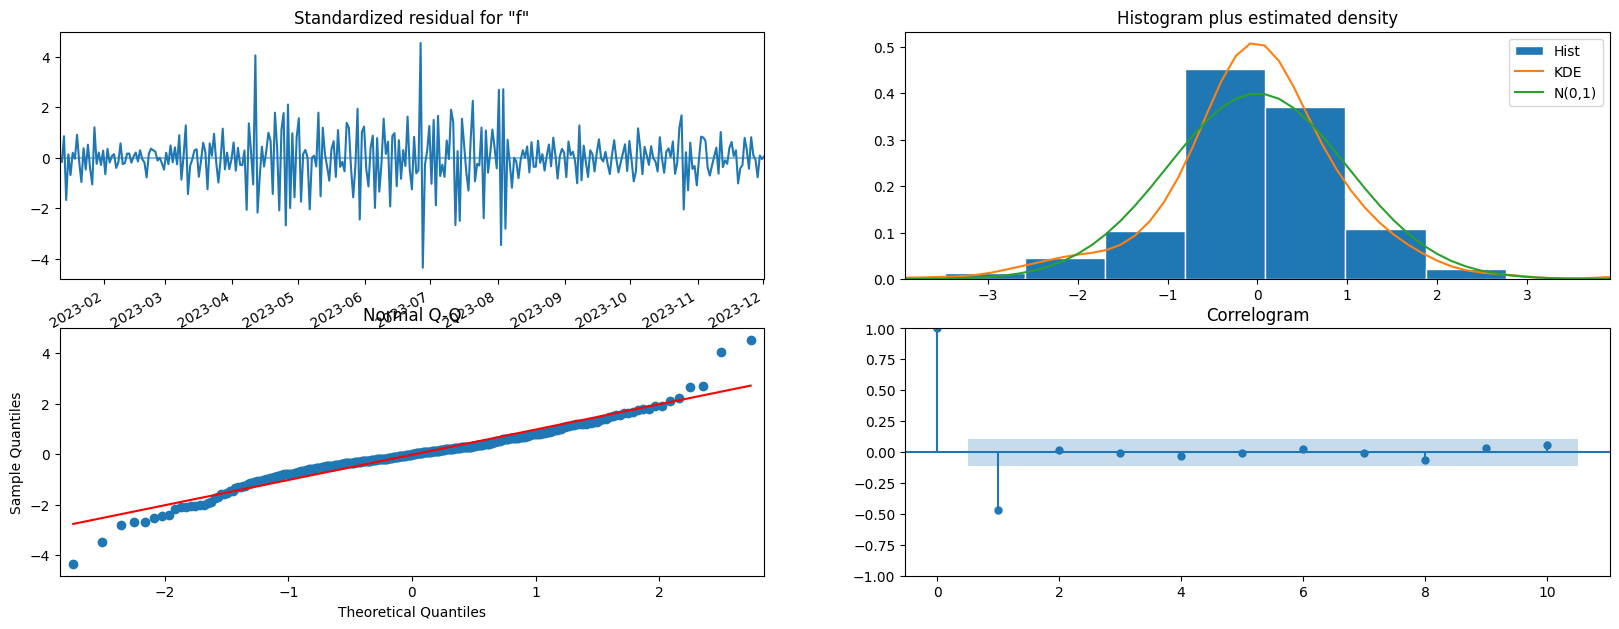

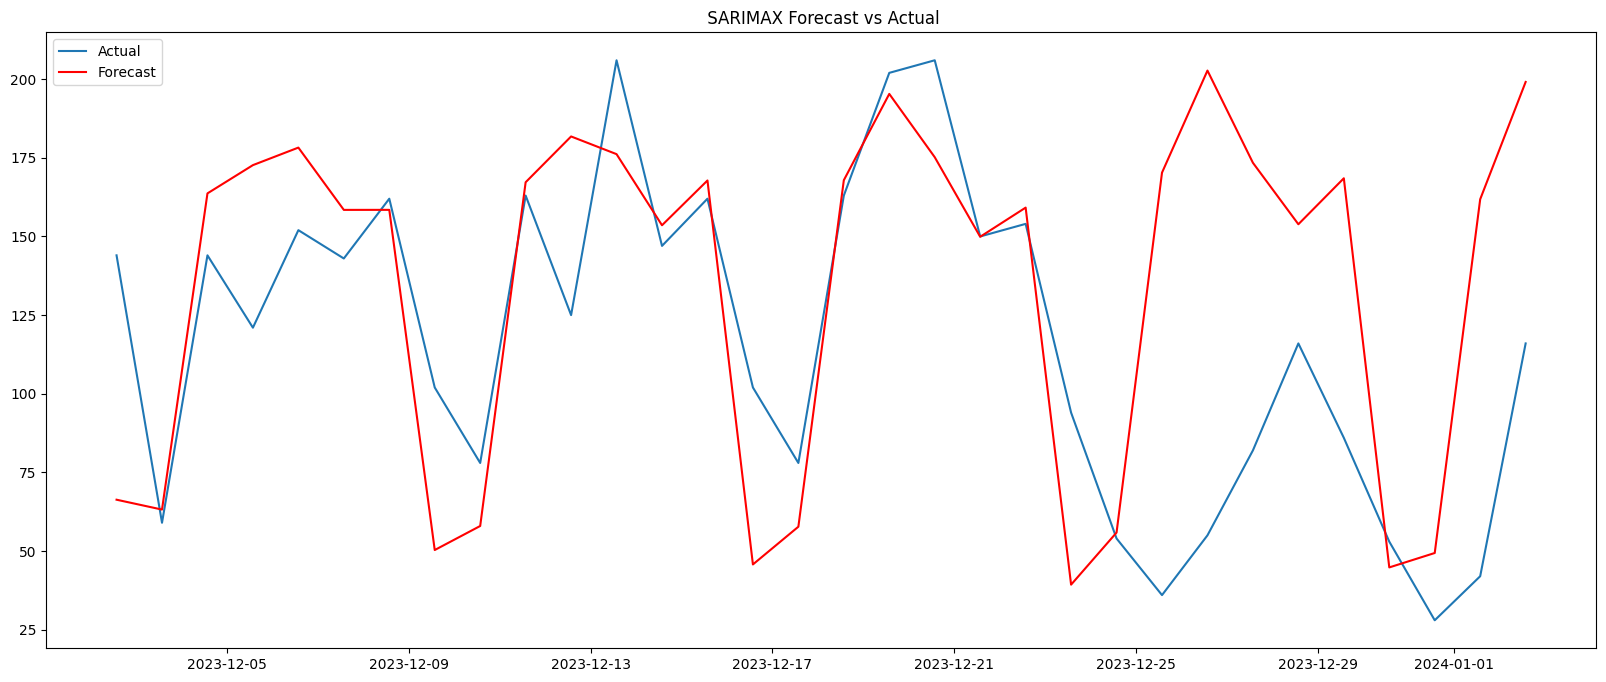

Mean Absolute Error (MAE): 40.01
Root Mean Squared Error (RMSE): 56.784
Mean Absolute Percentage Error (MAPE): 56.01%
Mean Absolute Scaled Error (MASE): 0.53%


In [50]:
model_d2 = SARIMAX(data_trainD2.filled_intensity, order=(0,1,0), seasonal_order=(5, 1,1, 7)) #(2, 1, 1, 7)
resultsd2 = model_d2.fit(disp=None)
#print(resultsd2.summary())

# Diagnostic plots
resultsd2.plot_diagnostics()
plt.show()

# Forecast and compare to test set
forecast_d2 = resultsd2.get_forecast(steps=len(data_testD2))
mean_forecast_d2 = forecast_d2.predicted_mean


plt.plot(data_testD2.index, data_testD2.filled_intensity, label='Actual')
plt.plot(mean_forecast_d2.index, mean_forecast_d2, color='red', label='Forecast')
#plt.fill_between(mean_forecast_simple.index, confidence_intervals_simple.iloc[:, 0], confidence_intervals_simple.iloc[:, 1], color='pink')
plt.title(' SARIMAX Forecast vs Actual')
plt.legend()
plt.show()

#evaluation
actual = data_testD2['filled_intensity'] 
predicted = mean_forecast_d2
training = data_trainD2['filled_intensity']

mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")

#### SARIMA (with all Exog)

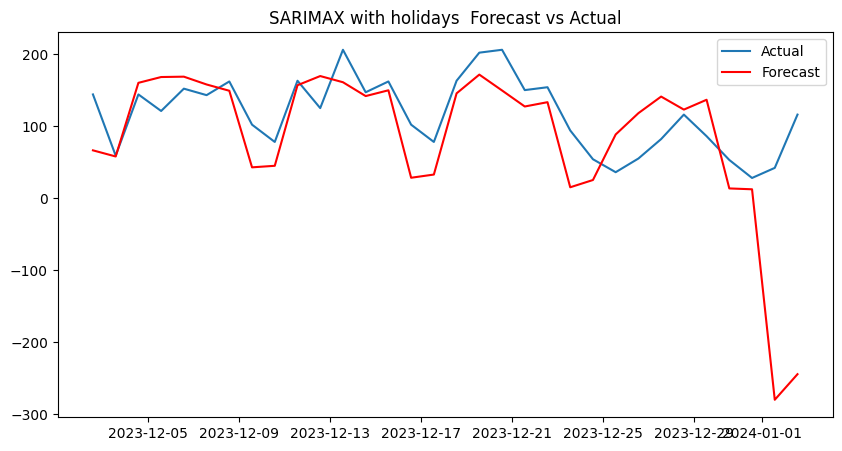

Mean Absolute Error (MAE): 54.26
Root Mean Squared Error (RMSE): 94.564
Mean Absolute Percentage Error (MAPE): 70.71%
Mean Absolute Scaled Error (MASE): 0.72%


In [51]:
# Fit the model with holidays as an exogenous variable
exog_data_train = data_trainD2[['is_holiday','dayofweek','month','hour','year']]
exog_data_test = data_testD2[['is_holiday','dayofweek','month','hour','year']]


model = SARIMAX(data_trainD2['filled_intensity'], exog=exog_data_train, order=(0,1,0), seasonal_order=(5, 1,1, 7)) #order=(0,1,0), seasonal_order=(5, 1,1, 7)
results = model.fit(disp=False)

# Forecast using the model
predictions = results.get_forecast(steps=len(data_testD2), exog=exog_data_test).predicted_mean

# Plot the forecast against the actual values
plt.figure(figsize=(10, 5))
plt.plot(data_testD2.index, data_testD2['filled_intensity'], label='Actual')
plt.plot(predictions.index, predictions, color='red', label='Forecast')
plt.title('SARIMAX with holidays  Forecast vs Actual')
plt.legend()
plt.show()

# evaluation 
actual = data_testD2['filled_intensity'] 
predicted = predictions
training = data_trainD2['filled_intensity']

mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")

#### SARIMAX (with one Exog) : BEST RESULT

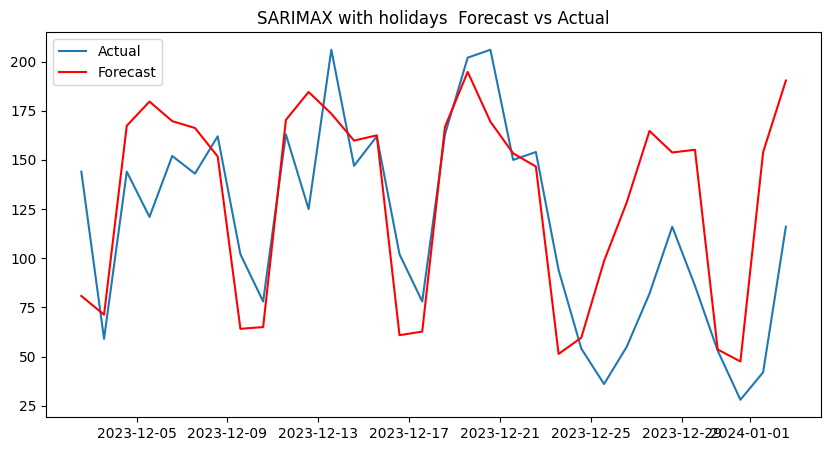

Mean Absolute Error (MAE): 33.35
Root Mean Squared Error (RMSE): 43.861
Mean Absolute Percentage Error (MAPE): 42.60%
Mean Absolute Scaled Error (MASE): 0.44%


In [76]:
# Fit the model with holidays as an exogenous variable
model = SARIMAX(data_trainD2['filled_intensity'], exog=data_trainD2['is_holiday'], order=(0,1,0), seasonal_order=(5, 1,1, 7)) #order=(0,1,0), seasonal_order=(5, 1,1, 7)
results = model.fit(disp=False)

# Forecast using the model
predictions_Best = results.get_forecast(steps=len(data_testD2), exog=data_testD2['is_holiday']).predicted_mean

# Plot the forecast against the actual values
plt.figure(figsize=(10, 5))
plt.plot(data_testD2.index, data_testD2['filled_intensity'], label='Actual')
plt.plot(predictions_Best.index, predictions_Best, color='red', label='Forecast')
plt.title('SARIMAX with holidays  Forecast vs Actual')
plt.legend()
plt.show()

# evaluation 
actual = data_testD2['filled_intensity'] 
predicted_Best = predictions_Best
training = data_trainD2['filled_intensity']

mae_Best = mean_absolute_error(actual, predicted_Best)
print(f"Mean Absolute Error (MAE): {mae_Best:.2f}")

rmse_Best = np.sqrt(mean_squared_error(actual, predicted_Best))
print(f"Root Mean Squared Error (RMSE): {rmse_Best:.3f}")

mape_Best = np.mean(np.abs((actual - predicted_Best) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape_Best:.2f}%")

mase_Best = calculate_mase(actual,predicted_Best,training)
print(f"Mean Absolute Scaled Error (MASE): {mase_Best:.2f}%")


### Prophet

In [53]:
holidayProphet = pd.DataFrame({
  'holiday': 'public_holiday',
  'ds': pd.to_datetime(['2023-01-01 13:40:00+00:00', '2023-01-06 13:40:00+00:00', '2023-04-07 13:40:00+00:00', '2023-04-10 13:40:00+00:00', '2023-05-01 13:40:00+00:00',
                        '2023-05-18 13:40:00+00:00', '2023-05-29 13:40:00+00:00','2023-06-03 13:40:00+00:00', '2023-06-08 13:40:00+00:00','2023-07-08 13:40:00+00:00','2023-09-02 13:40:00+00:00','2023-10-03 13:40:00+00:00', '2023-11-01 13:40:00+00:00',
                        '2023-12-25 13:40:00+00:00', '2023-12-26 13:40:00+00:00']),
  'lower_window': 0,
  'upper_window': 1,
})


In [55]:
data_prophet = data_ml.asfreq('D') 

test_start_date = data_prophet.index.max() - pd.DateOffset(months=1)

iloc_TrainEnd = data_prophet.index.get_loc(test_start_date)

# Define training and testing datasets
data_trainp = data_prophet.iloc[:iloc_TrainEnd]
data_testp = data_prophet.iloc[iloc_TrainEnd:]

# Print training and testing periods
print(f"Train dates : {data_trainD2.index.min()} --- {data_trainD2.index.max()}  (n={len(data_trainD2)})")
print(f"Test dates  : {data_testD2.index.min()} --- {data_testD2.index.max()}  (n={len(data_testD2)})")


Train dates : 2023-01-03 13:40:00+00:00 --- 2023-12-01 13:40:00+00:00  (n=333)
Test dates  : 2023-12-02 13:40:00+00:00 --- 2024-01-02 13:40:00+00:00  (n=32)


In [ ]:
data_mld = data_ml.asfreq('D') 

end = data_mld.index.max() - pd.DateOffset(months=1)
iloc_End = data_mld.index.get_loc(end)

data_prophet = data_mld.iloc[:iloc_End]
# Train-test dates

testEnd = data_prophet.index.max() - pd.DateOffset(months=1)
iloc_train = data_prophet.index.get_loc(testEnd)

# Define training and testing datasets
data_trainp = data_prophet.iloc[:iloc_train]
data_testp = data_prophet.iloc[iloc_train:]

# Print training and testing periods
print(f"Train dates : {data_trainp.index.min()} --- {data_trainp.index.max()}  (n={len(data_trainp)})")
print(f"Test dates  : {data_testp.index.min()} --- {data_testp.index.max()}  (n={len(data_testp)})")

###  Defult

In [56]:
# prepearing for model 
data_prophet = data_prophet.reset_index()
data_prophet = data_prophet.rename(columns ={'dateObserved': 'ds', 'filled_intensity':'y'})
data_trainp = data_trainp.reset_index()
data_trainp = data_trainp.rename(columns ={'dateObserved': 'ds', 'filled_intensity':'y'})
data_trainp['ds'] = data_trainp['ds'].dt.tz_localize(None)

data_testp = data_testp.reset_index()
data_testp = data_testp.rename(columns ={'dateObserved': 'ds', 'filled_intensity':'y'})
data_testp['ds'] = data_testp['ds'].dt.tz_localize(None)
forcast_df = data_testp.drop(columns ='y')

holidays= pd.DataFrame({
  'holiday': 'public_holiday',
  'ds': pd.to_datetime(['2023-05-29 13:40:00+0000'
                        ]),
  'lower_window': 0,
  'upper_window': 1,
})


prophet    INFO  Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
cmdstanpy  DEBUG input tempfile: /var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmp4wnxhzpu/8rksklzo.json
cmdstanpy  DEBUG input tempfile: /var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmp4wnxhzpu/5eagtn6n.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29211', 'data', 'file=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmp4wnxhzpu/8rksklzo.json', 'init=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmp4wnxhzpu/5eagtn6n.json', 'output', 'file=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmp4wnxhzpu/prophet_modelkxqi3377/proph

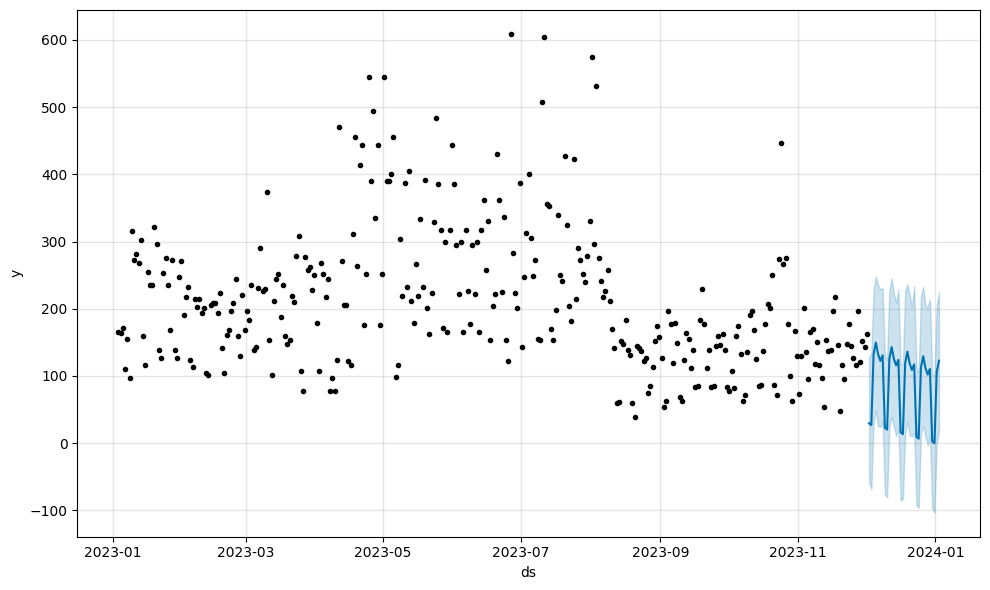

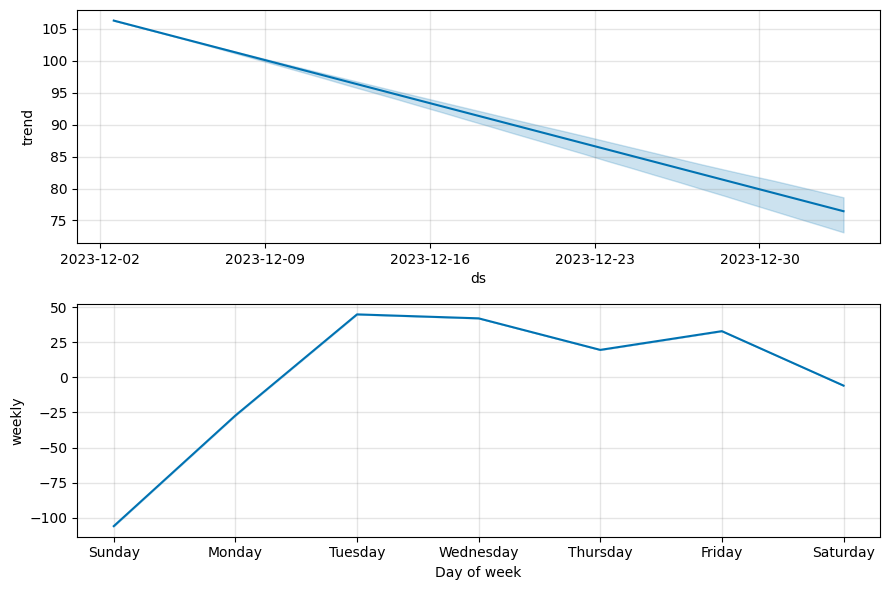

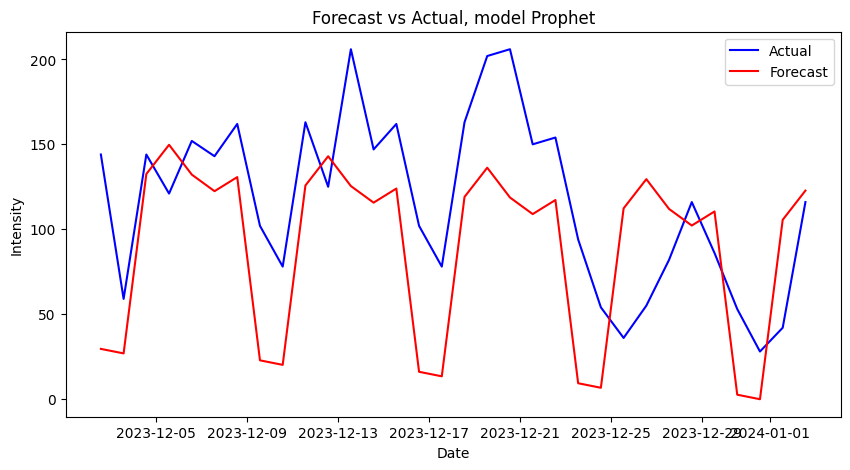

Mean Absolute Error (MAE): 47.69
Root Mean Squared Error (RMSE): 54.628
Mean Absolute Percentage Error (MAPE): 55.01%
Mean Absolute Scaled Error (MASE): 0.63%


In [57]:
model = Prophet()

model.fit(data_trainp)

forecast2 = model.predict(forcast_df)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = model.plot(forecast2)
fig2 = model.plot_components(forecast2)



plt.figure(figsize=(10, 5))
plt.plot(data_testp['ds'], data_testp['y'], label='Actual', color='blue')
plt.plot(forecast2['ds'], forecast2['yhat'], color='red', label='Forecast')
plt.title('Forecast vs Actual, model Prophet')
plt.xlabel('Date') 
plt.ylabel('Intensity') 
plt.legend()
plt.show()

# evaluation 
actual = data_testp['y'] 
predicted = forecast2['yhat']
training = data_trainp['y']

mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")

### Tuned 

In [58]:
# prepearing for model 
data_prophet = data_prophet.reset_index()
data_prophet = data_prophet.rename(columns ={'dateObserved': 'ds', 'filled_intensity':'y'})
data_trainp = data_trainp.reset_index()
data_trainp = data_trainp.rename(columns ={'dateObserved': 'ds', 'filled_intensity':'y'})
data_trainp['ds'] = data_trainp['ds'].dt.tz_localize(None)

data_testp = data_testp.reset_index()
data_testp = data_testp.rename(columns ={'dateObserved': 'ds', 'filled_intensity':'y'})
data_testp['ds'] = data_testp['ds'].dt.tz_localize(None)
forcast_df = data_testp.drop(columns ='y')

holidays= pd.DataFrame({
  'holiday': 'public_holiday',
  'ds': pd.to_datetime(['2023-05-29 13:40:00+0000'
                        ]),
  'lower_window': 0,
  'upper_window': 1,
})

cmdstanpy  DEBUG input tempfile: /var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmp4wnxhzpu/sdvwcruf.json
cmdstanpy  DEBUG input tempfile: /var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmp4wnxhzpu/4uwj4b2b.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79057', 'data', 'file=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmp4wnxhzpu/sdvwcruf.json', 'init=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmp4wnxhzpu/4uwj4b2b.json', 'output', 'file=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmp4wnxhzpu/prophet_modelw3sclom2/prophet_model-20240424235643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:56:43 - cmdstanpy - INFO - Chain [1] start processing
cmdstanpy  INFO  Chain [1] start processing
23:56:43 - cmdstanpy - INFO

Model 1
Mean Absolute Error (MAE): 47.97
Root Mean Squared Error (RMSE): 60.734
Mean Absolute Percentage Error (MAPE): 68.38%
Mean Absolute Scaled Error (MASE): 0.63%
Model 2
Mean Absolute Error (MAE): 39.21
Root Mean Squared Error (RMSE): 47.828
Mean Absolute Percentage Error (MAPE): 35.17%
Mean Absolute Scaled Error (MASE): 0.52%


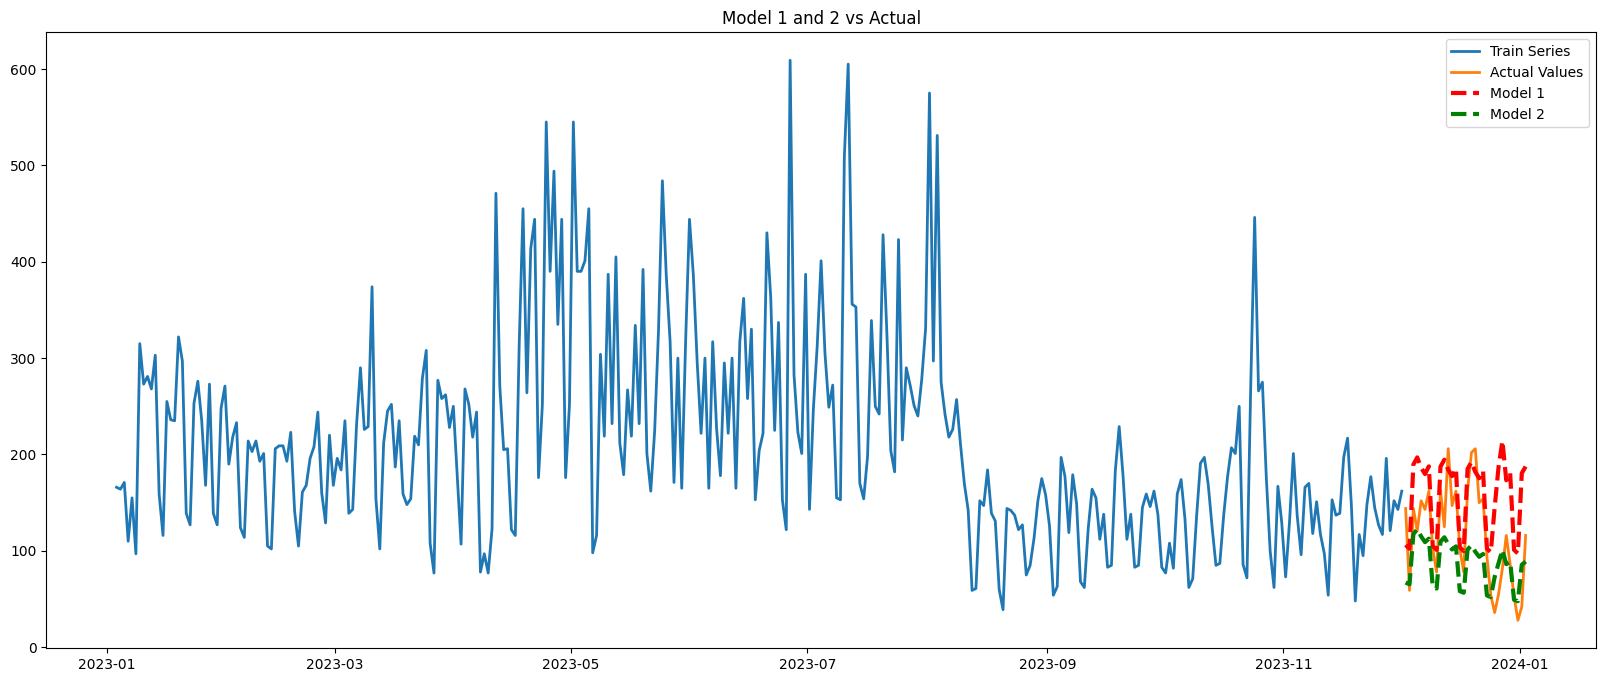

In [59]:
model = Prophet(
    changepoint_prior_scale=0.01905797698800418, 
    changepoint_range=0.7787414665722516, 
    daily_seasonality = True,
    #growth='linear',
    #interval_width=0.6134195282453077,
    n_changepoints=0,
    seasonality_mode= 'multiplicative', #'additive',
    seasonality_prior_scale=9.817619534889966,
    uncertainty_samples=1000, 
    #weekly_seasonality=False,
    yearly_seasonality= False, 
    #holidays= holidays
    holidays = holidayProphet
)

model.fit(data_trainp)

forecast = model.predict(forcast_df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#fig1 = model.plot(forecast)
#fig2 = model.plot_components(forecast)


# evaluation 
actual = data_testp['y'] 
predicted = forecast['yhat']
training = data_trainp['y']

print('Model 1')
mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")


# Model 2 
#========================================================

model = Prophet(
    changepoint_prior_scale=0.056412375199119064, 
    changepoint_range=0.6407631585364483, 
    #growth='linear',
    #daily_seasonality=True,
    #interval_width=0.18878144034686096,
    n_changepoints=5,
    seasonality_mode= 'multiplicative', #'additive',
    seasonality_prior_scale=1.883028744514034,
    uncertainty_samples=500, 
    #weekly_seasonality=True,
    yearly_seasonality= False, 
    #holidays= holidays
    holidays = holidayProphet
)

model.fit(data_trainp)

forecast2 = model.predict(forcast_df)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#fig1 = model.plot(forecast)
#fig2 = model.plot_components(forecast)

# evaluation 
actual = data_testp['y'] 
predicted2 = forecast2['yhat']
training = data_trainp['y']

print('Model 2')

mae = mean_absolute_error(actual, predicted2)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted2))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted2) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted2,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")


plt.plot(pd.to_datetime(data_trainp['ds']), data_trainp['y'], linewidth = 2, label = "Train Series")
plt.plot(pd.to_datetime(data_testp['ds']), data_testp['y'], linewidth = 2, label = "Actual Values")
plt.plot(forecast['ds'], forecast['yhat'], linewidth = 3, color='red', label = "Model 1", linestyle='dashed')
plt.plot(forecast2['ds'], forecast2['yhat'], linewidth = 3,color='green', label = "Model 2", linestyle='dashed')
plt.title('Model 1 and 2 vs Actual')
plt.legend()
plt.show()


cmdstanpy  DEBUG input tempfile: /var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmp4wnxhzpu/fgflxboq.json
cmdstanpy  DEBUG input tempfile: /var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmp4wnxhzpu/k_h8vmd1.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86727', 'data', 'file=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmp4wnxhzpu/fgflxboq.json', 'init=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmp4wnxhzpu/k_h8vmd1.json', 'output', 'file=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmp4wnxhzpu/prophet_model8_91rqmf/prophet_model-20240425000354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:03:54 - cmdstanpy - INFO - Chain [1] start processing
cmdstanpy  INFO  Chain [1] start processing
00:03:54 - cmdstanpy - INFO

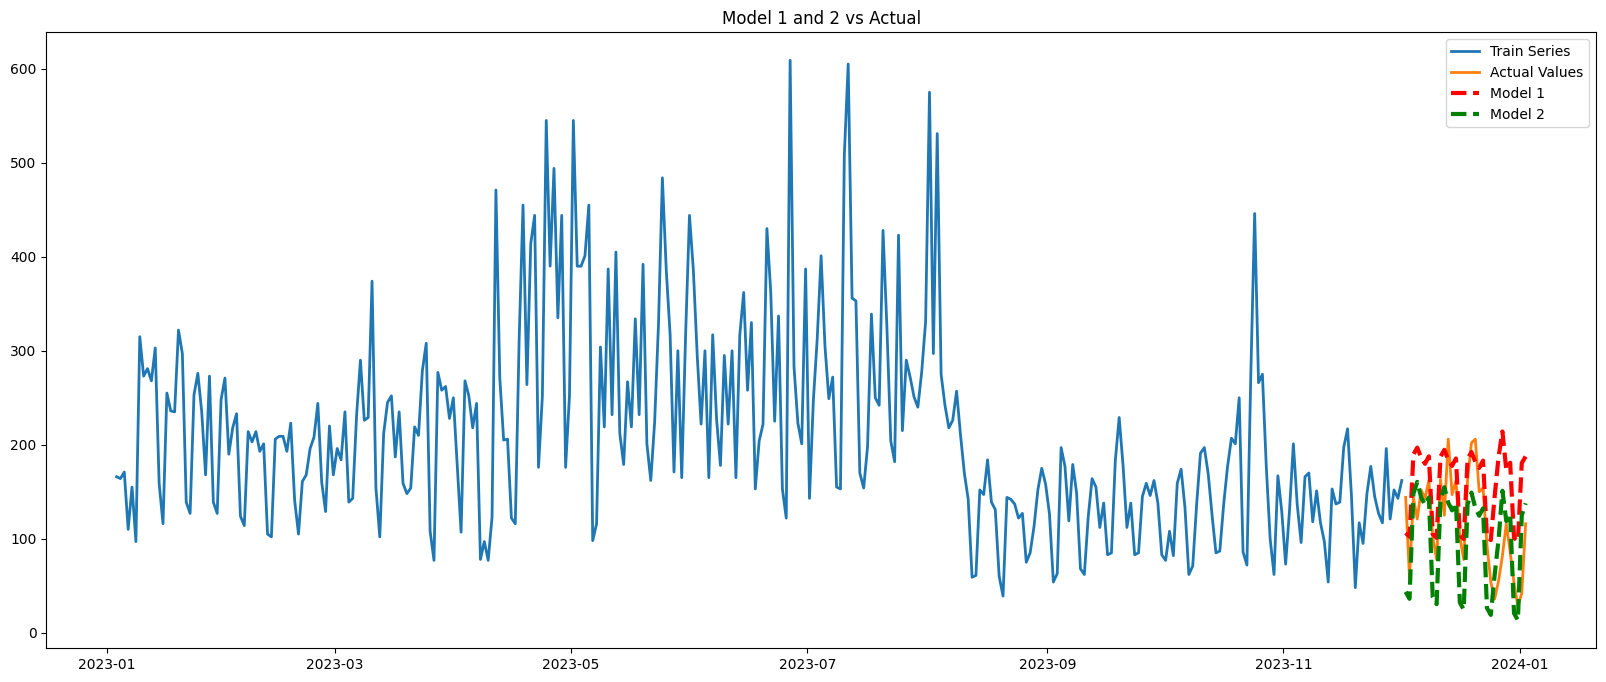

In [66]:
model = Prophet(
    changepoint_prior_scale=0.01905797698800418, 
    changepoint_range=0.7787414665722516, 
    daily_seasonality = True,
    #growth='linear',
    #interval_width=0.6134195282453077,
    n_changepoints=0,
    seasonality_mode= 'multiplicative', #'additive',
    seasonality_prior_scale=9.817619534889966,
    uncertainty_samples=1000, 
    #weekly_seasonality=False,
    yearly_seasonality= False, 
    #holidays= holidays
    holidays = holidayProphet
)

model.fit(data_trainp)

forecast = model.predict(forcast_df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#fig1 = model.plot(forecast)
#fig2 = model.plot_components(forecast)



# Model 2 
#========================================================


model = Prophet(
    changepoint_prior_scale= 0.03301367184677, 
    changepoint_range=0.4733, 
    #growth='linear',
    daily_seasonality=True,
    #interval_width= 0.24,
    #n_changepoints=5,
    seasonality_mode= 'additive', 
    seasonality_prior_scale=17, 
    uncertainty_samples=1000,
    #weekly_seasonality=True,
    yearly_seasonality= False, 
    holidays=holidayProphet
)

model.fit(data_trainp)

forecast2 = model.predict(forcast_df)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#fig1 = model.plot(forecast)
#fig2 = model.plot_components(forecast)



plt.plot(pd.to_datetime(data_trainp['ds']), data_trainp['y'], linewidth = 2, label = "Train Series")
plt.plot(pd.to_datetime(data_testp['ds']), data_testp['y'], linewidth = 2, label = "Actual Values")
plt.plot(forecast['ds'], forecast['yhat'], linewidth = 3, color='red', label = "Model 1", linestyle='dashed')
plt.plot(forecast2['ds'], forecast2['yhat'], linewidth = 3,color='green', label = "Model 2", linestyle='dashed')
plt.title('Model 1 and 2 vs Actual')
plt.legend()
plt.show()

In [67]:
# evaluation 
actual = data_testp['y'] 
predicted = forecast['yhat']
training = data_trainp['y']

print('Model 1')
mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")

actual = data_testp['y'] 
predicted2 = forecast2['yhat']
training = data_trainp['y']

print('Model 2')

mae2 = mean_absolute_error(actual, predicted2)
print(f"Mean Absolute Error (MAE): {mae2:.2f}")

rmse2 = np.sqrt(mean_squared_error(actual, predicted2))
print(f"Root Mean Squared Error (RMSE): {rmse2:.3f}")

mape2 = np.mean(np.abs((actual - predicted2) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape2:.2f}%")

mase2 = calculate_mase(actual,predicted2,training)
print(f"Mean Absolute Scaled Error (MASE): {mase2:.2f}%")



Model 1
Mean Absolute Error (MAE): 47.97
Root Mean Squared Error (RMSE): 60.734
Mean Absolute Percentage Error (MAPE): 68.38%
Mean Absolute Scaled Error (MASE): 0.63%
Model 2
Mean Absolute Error (MAE): 38.43
Root Mean Squared Error (RMSE): 45.715
Mean Absolute Percentage Error (MAPE): 43.20%
Mean Absolute Scaled Error (MASE): 0.51%


# Conclusion

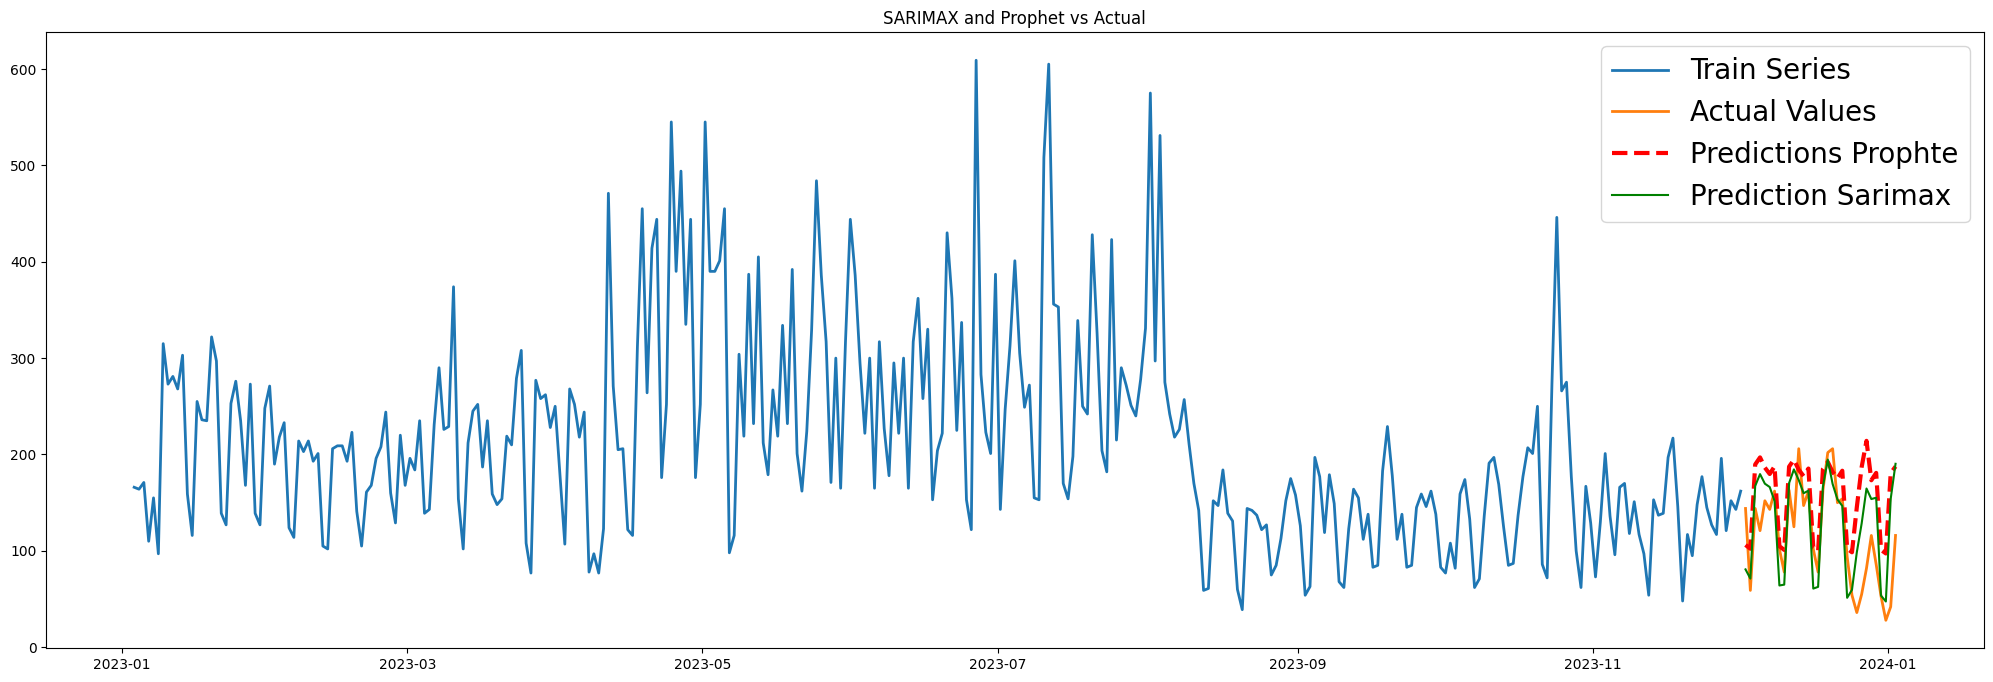

The best model is the SARIMAX Model, which we optimized and fine-tuned. It has the following metrics:
Mean Absolute Error (MAE): 33.35
Root Mean Squared Error (RMSE): 43.86
Mean Absolute Percentage Error (MAPE): 42.60%
Mean Absolute Scaled Error (MASE): 0.44%


In [78]:
f = plt.figure()
f.set_figwidth(25)
f.set_figheight(8)

plt.plot(pd.to_datetime(data_trainp['ds']), data_trainp['y'], linewidth = 2, label = "Train Series")
plt.plot(pd.to_datetime(data_testp['ds']), data_testp['y'], linewidth = 2, label = "Actual Values")
plt.plot(forecast['ds'], forecast['yhat'], linewidth = 3, color='red', label = "Predictions Prophte", linestyle='dashed')
plt.plot(predictions_Best.index, predictions_Best, color='green', label='Prediction Sarimax')
plt.title('SARIMAX and Prophet vs Actual')
plt.legend(fontsize=20)
plt.show()


print(f'The best model is the SARIMAX Model, which we optimized and fine-tuned. It has the following metrics:') 

mae_Best = mean_absolute_error(actual, predicted_Best)
print(f"Mean Absolute Error (MAE): {mae_Best:.2f}")

rmse_Best = np.sqrt(mean_squared_error(actual, predicted_Best))
print(f"Root Mean Squared Error (RMSE): {rmse_Best:.2f}")

mape_Best = np.mean(np.abs((actual - predicted_Best) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape_Best:.2f}%")

mase_Best = calculate_mase(actual,predicted_Best,training)
print(f"Mean Absolute Scaled Error (MASE): {mase_Best:.2f}%")
